<a href="https://colab.research.google.com/github/apapad02/DSC511-Project/blob/main/Steam_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steam Reviews Project** \\
We selected a dataset about Steam reviews in 2021 from Kaggle. You can see the link below: https://www.kaggle.com/datasets/najzeko/steam-reviews-2021 The dataset about Steam reviews is fascinating because it encapsulates a wealth of information on consumer preferences, behaviours, and sentiments within the vast PC gaming community. It serves as a rich corpus for sentiment analysis, enabling the development of advanced recommendation systems and the assessment of game features that resonate with or disappoint players. Additionally, this dataset can provide valuable feedback for developers and publishers, offering a direct line to consumer opinions on game performance, features, and potential improvements. We found the dataset interesting because, as students with programming backgrounds we are intrigued by video games both from a programming aspect but also from a “gamer” perspective. Part of our challenge was to view how the sentiment analysis will work in an environment where people use irony, jokes, and use of slang especially since we expect the average steam user to be of a younger age.
Our main subject of interest is the text analysis of the review combined with the actual review (positive or negative).  Using machine learning algorithms, we try to predict the recommended feature.
Also, we create a recommendation system and perform graph analysis on our dataset.

In [ ]:
!pip install pyspark==3.4.2
!pip install vaderSentiment
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619831 sha256=e6de3ee3235b10638876de1cb5dbff7ff1d8d05f448ff1ea2c0d73ac150a815a
  Stored in directory: /root/.cache/pip/wheels/0a/46/b6/5ca3debe11084c0ebb093d2809b6ae2844a6deebb11409a391
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Load libraries
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import expr
from sklearn.metrics import precision_recall_curve
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier,
                                       GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, count, when, sum
from textblob import TextBlob
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from collections import Counter
from nltk.tokenize import word_tokenize
from graphframes import GraphFrame
import networkx as nx
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Create a spark session and import graphframes
spark = SparkSession.builder.appName("ProjectM").config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
google_drive_path = "/content/gdrive/MyDrive/ERGASIA/"

Mounted at /content/gdrive


In [ ]:
# df = spark.read.csv(google_drive_path + 'steam_reviews.csv', header=True, inferSchema=True)

In [ ]:
#  from pyspark.sql.types import *
#  from pyspark.sql.functions import *
#  from pyspark.sql.window import Window

## Data Pre-processing

In [ ]:
# for column in df.columns:
#  df= df.withColumnRenamed(column,column.replace('.',"_"))
# df.show()

+---------------------------+----------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|                        _c0|    app_id|            app_name|review_id|language|                              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+---------------------------+----------+--------------------+---------+--------+--------------------------

In [ ]:
# df = df.filter(df["language"]=="english") # we keep only the english as language

In [ ]:
# df.count()

9635437

In [ ]:
# from pyspark.sql.functions import col, count, when, isnull

# null_counts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
# null_counts.show()

+---+------+--------+---------+--------+------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|app_name|review_id|language|review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+---+------+--------+---------+--------+------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+--------------+---------------------

Remove missing values and duplicates

We decided to drop all the missing values because by removing missing values helps keep our data analysis accurate because missing entries can sometimes lead to wrong conclusions if they're not evenly spread out. Since our dataset is quite large, dropping a few incomplete records won't significantly affect our overall results. This way, we make sure our analysis is based on complete and reliable information.



In [ ]:
# df = df.dropna()
# df.count()

7300865

In [ ]:
# df.dropDuplicates() # drop duplicates
# df.count()

7300865

We create a parquet file to use it, this will reduce the computational time needed for the tasks later.

In [ ]:
# df.coalesce(1).write \
#   .format("parquet") \
#   .save(google_drive_path + "output_file")


Our data set now (with only English as language) has 7300865 rows and 23 columns. A small description for each column:


- **_c0**: Represents a unique identifier or sequential index for each row in the dataset.
- **app_id**: Contains the unique identifier for each application or game reviewed.
- **app_name**: The name of the application or game that has been reviewed.
- **review_id**: A unique identifier for each individual review.
- **language**: The language in which the review has been written.
- **review**: Contains the actual text of the review left by the user.
- **timestamp_created**: Unix timestamp indicating when the review was originally created.
- **timestamp_updated**: Unix timestamp showing when the review was last updated.
- **recommended**: Boolean value indicating whether the reviewer recommends the game or application.
- **votes_helpful**: Number of times other users have found this review helpful.
- **votes_funny**: Number of times other users have found this review funny.
- **weighted_vote_score**: A score that represents a weighted measure of the review's helpfulness or quality.
- **comment_count**: Number of comments other users have left on this review.
- **steam_purchase**: Boolean value indicating whether the reviewer purchased the game on Steam.
- **received_for_free**: Boolean value indicating whether the reviewer received the product for free.
- **written_during_early_access**: Boolean value showing whether the review was written while the game was still in early access.
- **author_steamid**: Unique Steam ID of the reviewer.
- **author_num_games_owned**: Number of games owned by the reviewer on Steam.
- **author_num_reviews**: Number of reviews the user has written on Steam.
- **author_playtime_forever**: Total playtime in minutes the reviewer has spent on the game being reviewed, across all time.
- **author_playtime_last_two_weeks**: Total playtime in minutes the reviewer has spent on the game in the last two weeks.
- **author_playtime_at_review**: Playtime in minutes that the reviewer had at the time of writing the review.
- **author_last_played**: Unix timestamp of the last time the reviewer played the game.

In [ ]:
df = spark.read.parquet(google_drive_path + "output_file")
print("Number of rows: " + str(df.count()) + ", Number of columns:"+ str(len(df.columns)))
df.show()

Number of rows: 7300865, Number of columns:23
+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-

We created a sample, stratified sampling.

In [ ]:
# get the counts of each category in app_id
class_counts = df.groupBy("app_id").count()

# Calculate the total number of instances in the DataFrame
total_count = df.count()

fractions = class_counts.rdd.map(lambda row: (row["app_id"], row["count"] / total_count)).collectAsMap()

# Sample 80% of the data but keep the distribution of app_id the same
sample_fractions = {k: v * 0.8 for k, v in fractions.items()}

# Perform stratified sampling without splitting
df = df.stat.sampleBy("app_id", fractions=sample_fractions, seed=1234)

# Count the occurrences of each distinct app_id
df.groupBy("app_id","app_name").count().show(100)

+-------+--------------------+-----+
| app_id|            app_name|count|
+-------+--------------------+-----+
|   8930|Sid Meier's Civil...|  792|
| 620980|          Beat Saber|   81|
| 577800|            NBA 2K18|    2|
| 583950|            Artifact|    4|
| 728880|       Overcooked! 2|    4|
|   4000|         Garry's Mod| 8031|
| 504230|             Celeste|   13|
| 247730|              Nether|    6|
| 381210|    Dead by Daylight| 1391|
| 285190|Warhammer 40,000:...|    1|
|   2870|           X Rebirth|    2|
| 253230|       A Hat in Time|   28|
| 242760|          The Forest|  556|
| 264710|          Subnautica|  460|
| 292030|The Witcher 3: Wi...| 1550|
| 841370|            NBA 2K19|    1|
| 621060|PC Building Simul...|   18|
|    240|Counter-Strike: S...|  151|
|1128000|          Cube World|    5|
| 332200|         Axiom Verge|    1|
|1056960|Wolfenstein: Youn...|    1|
| 250900|The Binding of Is...|  225|
| 477160|    Human: Fall Flat|   41|
| 834910|               ATLAS|   19|
|

In [ ]:
# df = df.sample(withReplacement=False, fraction=0.01, seed=29)

# print(df.count())
# df.show()

In [ ]:
df.printSchema() # print schema

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playt

In [ ]:
# Returns how many rows in each column are non numeric
def get_non_numeric_counts(df, columns):
    non_numeric_counts = {}
    for column in columns:
        count = df.filter(~col(column).rlike("^-?\d+(\.\d+)?$")).count()
        non_numeric_counts[column] = count
    return non_numeric_counts

# List of columns to check
column_list = [
    'timestamp_created', 'timestamp_updated',"app_id","review_id","_c0",
    'votes_helpful', 'votes_funny', 'weighted_vote_score',
    'comment_count',
     'author_steamid', 'author_num_games_owned',
    'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks',
    'author_playtime_at_review', 'author_last_played'
]

# Get the non-numeric counts
non_numeric_count_table = get_non_numeric_counts(df, column_list)

# print the result
for column, count in non_numeric_count_table.items():
    print(f"{column}: {count}")

timestamp_created: 586
timestamp_updated: 340
app_id: 0
review_id: 0
_c0: 0
votes_helpful: 401
votes_funny: 224
weighted_vote_score: 157
comment_count: 106
author_steamid: 462
author_num_games_owned: 254
author_num_reviews: 170
author_playtime_forever: 112
author_playtime_last_two_weeks: 83
author_playtime_at_review: 60
author_last_played: 44


In [ ]:
# Keep the values in specified columns that match a numerical format
for column in column_list:
    df = df.filter(col(column).rlike("^-?\d+(\.\d+)?$"))

In [ ]:
df.count() # num of rows

87659

In [ ]:
def count_non_true_false(df, columns):
  result_str = ""
  for column in columns:
    # Count the number of non-boolean values in the column
    invalid_rows_count = df.filter(~col(column).isin(['true', 'false', 'True', 'False'])).count()
    # Append the count to the result string with the column name
    result_str += f"{column}: {invalid_rows_count}\n"

  return result_str.strip()

# List of column names to check for non-boolean  values
columns_to_check = ['recommended', 'steam_purchase', 'received_for_free', 'written_during_early_access']
result = count_non_true_false(df, columns_to_check)
print(result)

recommended: 0
steam_purchase: 0
received_for_free: 0
written_during_early_access: 0


In [ ]:
# Convert data types
df = df.withColumn("votes_helpful", col("votes_helpful").cast(IntegerType()))
df = df.withColumn("votes_funny", col("votes_funny").cast(IntegerType()))
df = df.withColumn("weighted_vote_score", col("weighted_vote_score").cast(FloatType()))
df = df.withColumn("comment_count", col("comment_count").cast(IntegerType()))
df = df.withColumn("author_num_reviews", col("author_num_reviews").cast(IntegerType()))
df = df.withColumn("author_num_games_owned", col("author_num_games_owned").cast(IntegerType()))
df = df.withColumn("author_playtime_forever", col("author_playtime_forever").cast(IntegerType()))
df = df.withColumn("author_playtime_last_two_weeks", col("author_playtime_last_two_weeks").cast(IntegerType()))
df = df.withColumn("author_playtime_at_review", col("author_playtime_at_review").cast(IntegerType()))
df = df.withColumn("author_last_played", col("author_last_played").cast(FloatType()))

In [ ]:
# Convert Boolean columns to numeric
boolean_columns = ["recommended", "steam_purchase", "received_for_free", "written_during_early_access"]

for column_name in boolean_columns:
    df = df.withColumn(f"{column_name}_numeric",
                       when(col(column_name) == "True", 1)
                       .when(col(column_name) == "False", 0)
                       .otherwise(None))
df.show(5)

+----+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+
| _c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|recommended_numeric|steam_purchase_numeric|received_for_free_numeric|written_during_earl

## Exploratory Data Analysis (EDA)

In [ ]:
# Count the reviews for each app
from pyspark.sql.functions import count

review_counts = df.groupBy("app_name", "app_id").agg(count("review_id").alias("review_count"))
review_counts.show()

+--------------------+-------+------------+
|            app_name| app_id|review_count|
+--------------------+-------+------------+
|          The Forest| 242760|         554|
|             Celeste| 504230|          13|
|Warhammer 40,000:...| 285190|           1|
|            Stay Out|1180380|           1|
|Sid Meier's Civil...| 289070|         295|
|              Nether| 247730|           6|
|            Portal 2|    620|         795|
|            NBA 2K19| 841370|           1|
|    Dead by Daylight| 381210|        1385|
|         Axiom Verge| 332200|           1|
|The Witcher 3: Wi...| 292030|        1541|
|Half-Life 2: Epis...|    420|           9|
|Counter-Strike: S...|    240|         150|
|               ATLAS| 834910|          18|
|Call of Duty: Inf...| 292730|           5|
|    Human: Fall Flat| 477160|          41|
|The Binding of Is...| 250900|         224|
|          Beat Saber| 620980|          81|
|          Cube World|1128000|           5|
|           Half-Life|     70|  

In [ ]:
# App with the least reviews

review_counts.sort("review_count").first()["app_name"]

'Warhammer 40,000: Dawn of War III'

In [ ]:
# App with the most reviews

most_reviews_row = review_counts.sort("review_count", ascending=False).first()
print("App Name with the most Reviews:", most_reviews_row["app_name"])
print("Review Count:", most_reviews_row["review_count"])


App Name with the most Reviews: Terraria
Review Count: 10010


Number of distinct app_id: 236


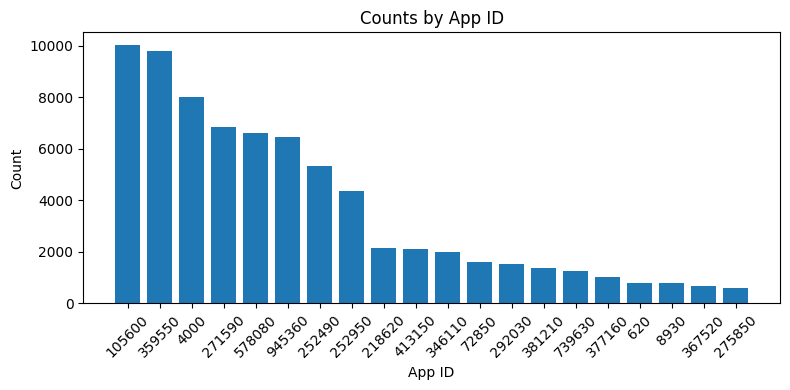

In [ ]:
# app_id

# Number of distinct app_ids
distinct_app_id_count = df.select('app_id').distinct().count()
print(f"Number of distinct app_id: {distinct_app_id_count}")

# Barplot of the frequency of app_id
app_id_counts = df.groupBy("app_id").count().withColumnRenamed("count", "count_of_app_id").orderBy("count_of_app_id", ascending=False).limit(20).toPandas()
plt.figure(figsize=(8, 4))
plt.bar(app_id_counts['app_id'], app_id_counts['count_of_app_id'])
plt.xlabel('App ID')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by App ID')  # Title of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable
plt.tight_layout()
plt.show()

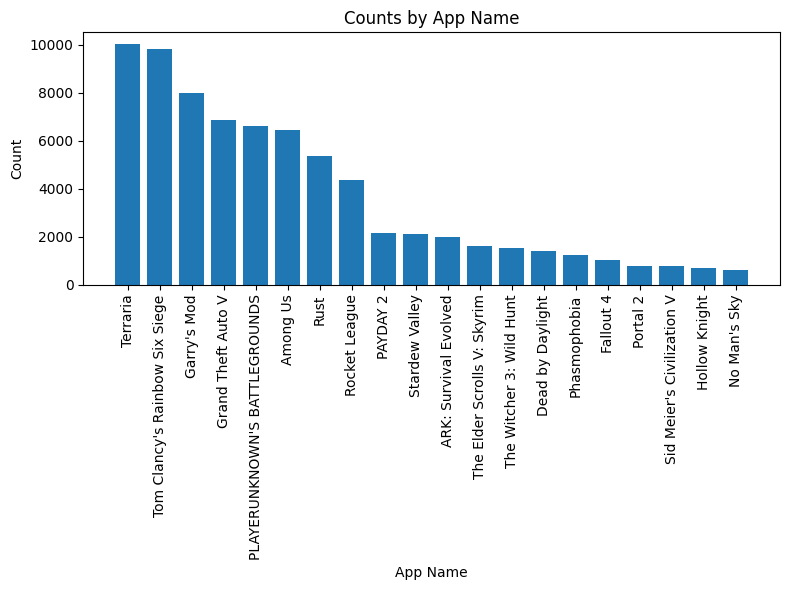

In [ ]:
# app_name

# Barplot of the frequency of app_name
app_name_counts = df.groupBy("app_name").count().withColumnRenamed("count", "count_of_app_name").orderBy("count_of_app_name", ascending=False).limit(20).toPandas() # count of occurences for each app_name
plt.figure(figsize=(8, 6))
plt.bar(app_name_counts['app_name'], app_name_counts['count_of_app_name'])
plt.xlabel('App Name')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by App Name')  # Title of the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels to make them more readable
plt.tight_layout()
plt.show()

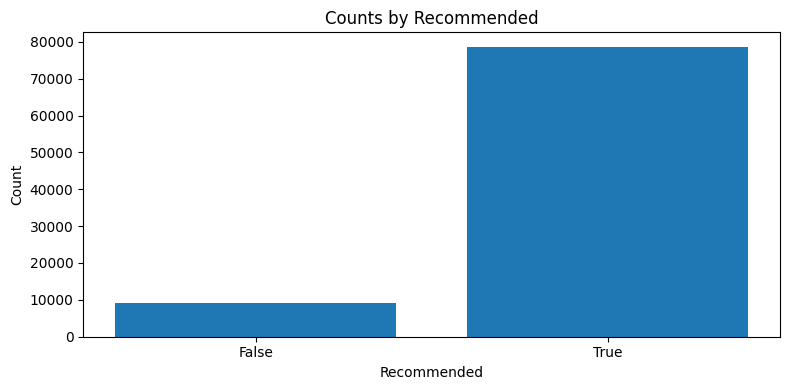

In [ ]:
# recommended

# Barplot of the frequency of recommended
recommended_counts = df.groupBy("recommended").count().withColumnRenamed("count", "count_of_recommended").orderBy("count_of_recommended").toPandas() # count of occurences for recommended or not
plt.figure(figsize=(8, 4))
plt.bar(recommended_counts['recommended'], recommended_counts['count_of_recommended'])
plt.xlabel('Recommended')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by Recommended')  # Title of the plot
plt.tight_layout()
plt.show()

In [ ]:
df.groupBy("recommended").count().withColumnRenamed("count", "count_of_recommended").orderBy("count_of_recommended").show()

+-----------+--------------------+
|recommended|count_of_recommended|
+-----------+--------------------+
|      False|                9030|
|       True|               78629|
+-----------+--------------------+



We can observe that the 'recommended' variable, which is our response is very imbalanced. The majority of the reviews recommend the apps.

Number of distinct votes_helpful: 139


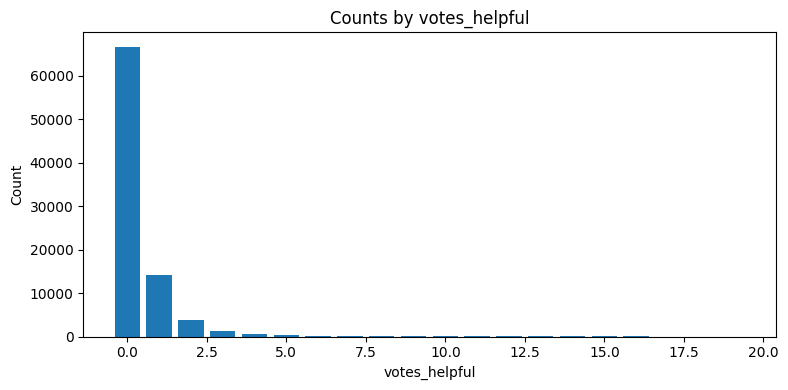

In [ ]:
# votes_helpful

# Number of distinct votes_helpful
distinct_votes_helpful_count = df.select('votes_helpful').distinct().count()
print(f"Number of distinct votes_helpful: {distinct_votes_helpful_count}")

votes_helpful_counts = df.groupBy("votes_helpful").count().withColumnRenamed("count", "count_of_votes_helpful").orderBy("count_of_votes_helpful", ascending=False).limit(20).toPandas() # count of occurences for votes_helpful
plt.figure(figsize=(8, 4))
plt.bar(votes_helpful_counts['votes_helpful'], votes_helpful_counts['count_of_votes_helpful'])
plt.xlabel('votes_helpful')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by votes_helpful')  # Title of the plot
plt.tight_layout()
plt.show()

The majority of the reviews have no helpful votes.

In [ ]:
# Try to find the review that has the most votes_helpful

# Order the DataFrame by 'votes_helpful' in descending order and take the top 10
top_reviews = df.orderBy(col("votes_helpful").desc()).select("review_id","review", "votes_helpful").limit(10)
top_reviews.show()
top_reviews_list = top_reviews.collect()

print("Top 10 Reviews based on the number of votes_helpful\n")
# Print the top 10 reviews based on the number of votes_helpful
for row in top_reviews_list:
    print(f"Review: {row['review']}, Votes Helpful: {row['votes_helpful']}")

+---------+--------------------+-------------+
|review_id|              review|votes_helpful|
+---------+--------------------+-------------+
| 24846676|The refund button...|         4718|
| 15656756|Rockstar is anti-...|         2892|
| 34175809|"GAME IS AMAZING....|         1822|
| 15508599|Khajiit has mods,...|         1418|
| 28213294|2 hours into the ...|         1168|
| 50737954|You either die by...|          910|
| 67535630|like minecraft wi...|          757|
| 81866102|               grape|          713|
| 76015136|     MY WIFE LEFT ME|          686|
| 45072505|It is like beeing...|          666|
+---------+--------------------+-------------+

Top 10 Reviews based on the number of votes_helpful

Review: The refund button works well., Votes Helpful: 4718
Review: Rockstar is anti-modding, there is nothing more to say., Votes Helpful: 2892
Review: "GAME IS AMAZING. MICROTRANSACTIONS AND BEING BANNED FOR HONKING A HORN = STUPID. WE PAY FOR EARLY ACCESS... AND YOU STATE THAT ""game i

Number of distinct votes_funny: 97


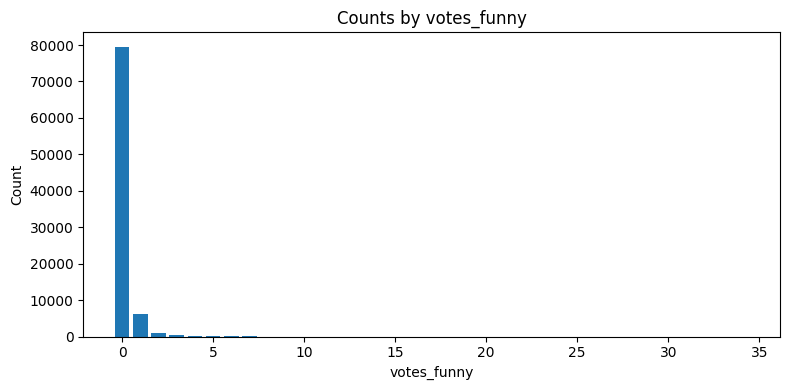

In [ ]:
# votes_funny

# Number of distinct votes_funny
distinct_votes_funny_count = df.select('votes_funny').distinct().count()
print(f"Number of distinct votes_funny: {distinct_votes_funny_count}")

votes_funny_counts = df.groupBy("votes_funny").count().withColumnRenamed("count", "count_of_votes_funny").orderBy("count_of_votes_funny", ascending=False).limit(20).toPandas() # count of occurences for votes_funny
plt.figure(figsize=(8, 4))
plt.bar(votes_funny_counts['votes_funny'], votes_funny_counts['count_of_votes_funny'])
plt.xlabel('votes_funny')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by votes_funny')  # Title of the plot
plt.tight_layout()
plt.show()

The majority of the reviews have no votes funny.

In [ ]:
# Try to find the review that has the most votes_funny

# Order the DataFrame by 'votes_funny' in descending order and take the top 10
top_reviews = df.orderBy(col("votes_funny").desc()).select("review_id","review", "votes_funny").limit(10)
top_reviews.show()
top_reviews_list = top_reviews.collect()

print("Top 10 Reviews based on the number of votes_funny\n")
# Print the top 10 reviews based on the number of votes_funny
for row in top_reviews_list:
    print(f"Review: {row['review']}, Votes Funny: {row['votes_funny']}")

+---------+--------------------+-----------+
|review_id|              review|votes_funny|
+---------+--------------------+-----------+
| 24846676|The refund button...|      12364|
| 15508599|Khajiit has mods,...|       2536|
| 50737954|You either die by...|       1491|
| 15562929|I forgot about th...|        896|
| 34231352|gingers dont have...|        659|
| 44876188|You can do everyt...|        614|
| 65087657|WHO THE HELL IS G...|        590|
| 76015136|     MY WIFE LEFT ME|        490|
| 45072505|It is like beeing...|        470|
| 65825676|I can pretend lik...|        323|
+---------+--------------------+-----------+

Top 10 Reviews based on the number of votes_funny

Review: The refund button works well., Votes Funny: 12364
Review: Khajiit has mods, if you have coin., Votes Funny: 2536
Review: You either die by a spawn peeker, or you live long enough to see yourself become the spawn peeker., Votes Funny: 1491
Review: I forgot about the other 223 games I have on Steam., Votes Funn

In [ ]:
# comment_count
df.select('comment_count').describe().show()

+-------+-------------------+
|summary|      comment_count|
+-------+-------------------+
|  count|              87659|
|   mean|0.08462337010460991|
| stddev| 1.4330617954784295|
|    min|                  0|
|    max|                296|
+-------+-------------------+



Number of distinct comment_count: 36


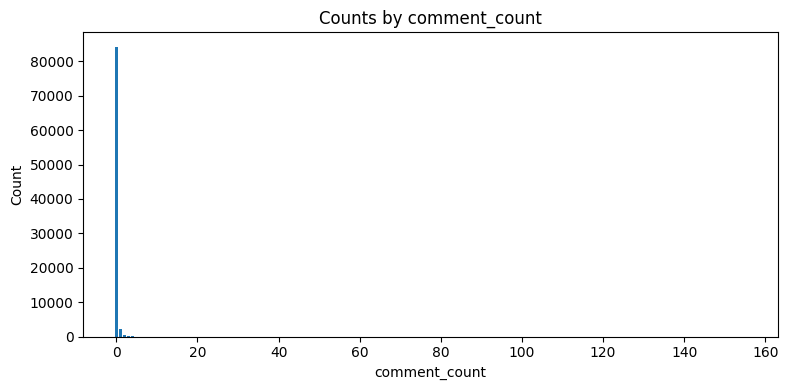

In [ ]:
# Number of distinct comment_count
distinct_comment_count = df.select('comment_count').distinct().count()
print(f"Number of distinct comment_count: {distinct_comment_count}")

# Barplot of comment_count
comment_count_counts = df.groupBy("comment_count").count().withColumnRenamed("count", "count_of_comment_count").orderBy("count_of_comment_count", ascending=False).limit(20).toPandas() # count of occurences for comment_count
plt.figure(figsize=(8, 4))
plt.bar(comment_count_counts['comment_count'], comment_count_counts['count_of_comment_count'])
plt.xlabel('comment_count')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by comment_count')  # Title of the plot
plt.tight_layout()
plt.show()

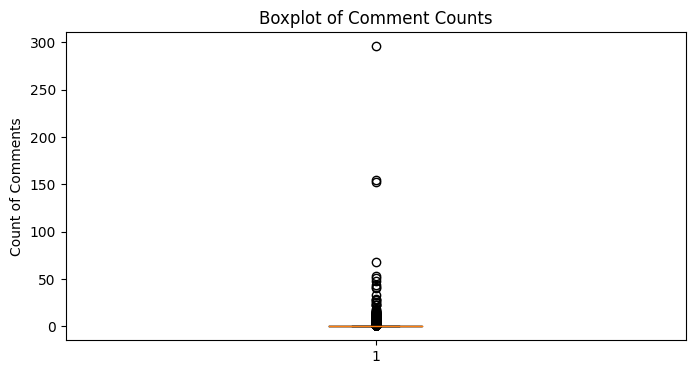

In [ ]:
# Boxplot of comment_count
pandas_comment_count = df.select("comment_count").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(pandas_comment_count['comment_count'])
plt.title("Boxplot of Comment Counts")
plt.ylabel("Count of Comments")
plt.show()

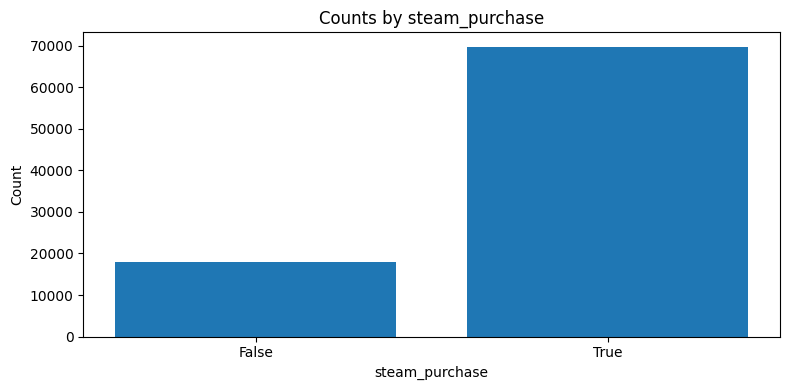

In [ ]:
# steam_purchase

# Barplot of the frequency of steam_purchase
steam_purchase_counts = df.groupBy("steam_purchase").count().withColumnRenamed("count", "count_of_steam_purchase").orderBy("count_of_steam_purchase").toPandas() # count of occurences for steam_purchase or not
plt.figure(figsize=(8, 4))
plt.bar(steam_purchase_counts['steam_purchase'], steam_purchase_counts['count_of_steam_purchase'])
plt.xlabel('steam_purchase')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by steam_purchase')  # Title of the plot
plt.tight_layout()
plt.show()

The most reviewers bought the games directly from the Steam.

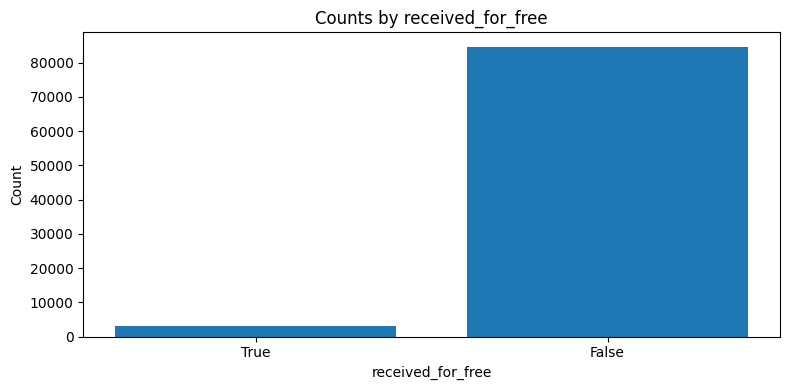

In [ ]:
# received_for_free

received_for_free_counts = df.groupBy("received_for_free").count().withColumnRenamed("count", "count_of_received_for_free").orderBy("count_of_received_for_free").toPandas() # count of occurences for received_for_free or not
plt.figure(figsize=(8, 4))
plt.bar(received_for_free_counts['received_for_free'], received_for_free_counts['count_of_received_for_free'])
plt.xlabel('received_for_free')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by received_for_free')  # Title of the plot
plt.tight_layout()
plt.show()

The majority of the games are not free

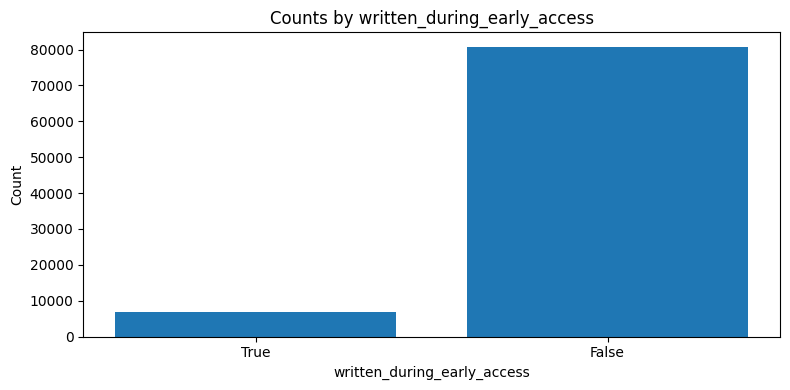

In [ ]:
# written_during_early_access

written_during_early_access_counts = df.groupBy("written_during_early_access").count().withColumnRenamed("count", "count_of_written_during_early_access").orderBy("count_of_written_during_early_access").toPandas() # count of occurences for written_during_early_access or not
plt.figure(figsize=(8, 4))
plt.bar(written_during_early_access_counts['written_during_early_access'], written_during_early_access_counts['count_of_written_during_early_access'])
plt.xlabel('written_during_early_access')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by written_during_early_access')  # Title of the plot
plt.tight_layout()
plt.show()

The most reviews did not written during early access.

Number of distinct author_steamid: 86875


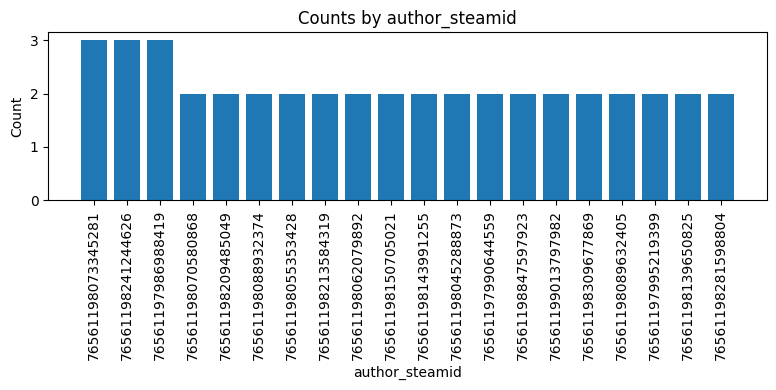

In [ ]:
# author_steamid

# Number of distinct author_steamid
author_steamid_count = df.select('author_steamid').distinct().count()
print(f"Number of distinct author_steamid: {author_steamid_count}")

# Barplot of the frequency of author_steamid
author_steamid_counts = df.groupBy("author_steamid").count().withColumnRenamed("count", "count_of_author_steamid").orderBy("count_of_author_steamid", ascending=False).limit(20).toPandas()
plt.figure(figsize=(8, 4))
plt.bar(author_steamid_counts['author_steamid'], author_steamid_counts['count_of_author_steamid'])
plt.xlabel('author_steamid')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.title('Counts by author_steamid')  # Title of the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels to make them more readable
plt.tight_layout()
plt.show()

In [ ]:
# author_num_games_owned
df.select("author_num_games_owned").describe().show()

+-------+----------------------+
|summary|author_num_games_owned|
+-------+----------------------+
|  count|                 87659|
|   mean|    111.99215140487571|
| stddev|    213.90093552685323|
|    min|                     0|
|    max|                 11435|
+-------+----------------------+



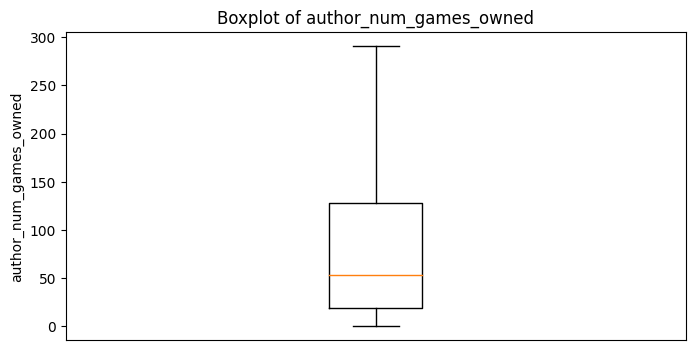

In [ ]:
# Boxplot of author_num_games_owned
author_num_games_owned_df = df.select("author_num_games_owned").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(author_num_games_owned_df['author_num_games_owned'], showfliers=False)  # Hide outliers
plt.title("Boxplot of author_num_games_owned")
plt.ylabel("author_num_games_owned")
plt.xticks([])  # Remove x-axis tick labels
plt.show()

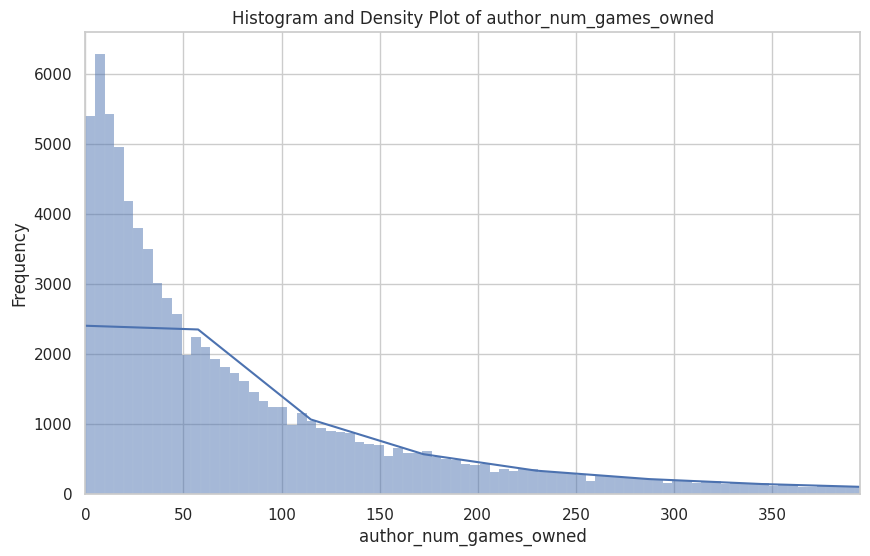

In [ ]:
# Histogram and density of author_num_games_owned
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Create the histogram with a density plot overlay, setting the bins to be more appropriate for the range of data
sns.histplot(author_num_games_owned_df['author_num_games_owned'], kde=True)  # Adjust the number of bins as necessary

# Setting the limits for the x-axis
plt.xlim(0, author_num_games_owned_df['author_num_games_owned'].quantile(0.95))  # Adjust the quantile as necessary

# Adding labels and title
plt.xlabel('author_num_games_owned')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram and Density Plot of author_num_games_owned')  # Title of the plot
plt.show()

In [ ]:
# author_num_reviews
df.select("author_num_reviews").describe().show()

+-------+------------------+
|summary|author_num_reviews|
+-------+------------------+
|  count|             87659|
|   mean| 7.892857550280063|
| stddev|17.353847844894638|
|    min|                 1|
|    max|               841|
+-------+------------------+



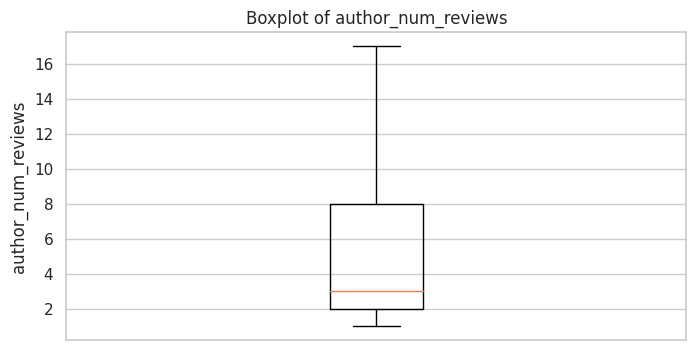

In [ ]:
# Boxplot of author_num_reviews
author_num_reviews_df = df.select("author_num_reviews").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(author_num_reviews_df['author_num_reviews'], showfliers=False)  # Hide outliers
plt.title("Boxplot of author_num_reviews")
plt.ylabel("author_num_reviews")
plt.xticks([])  # Remove x-axis tick labels
plt.show()

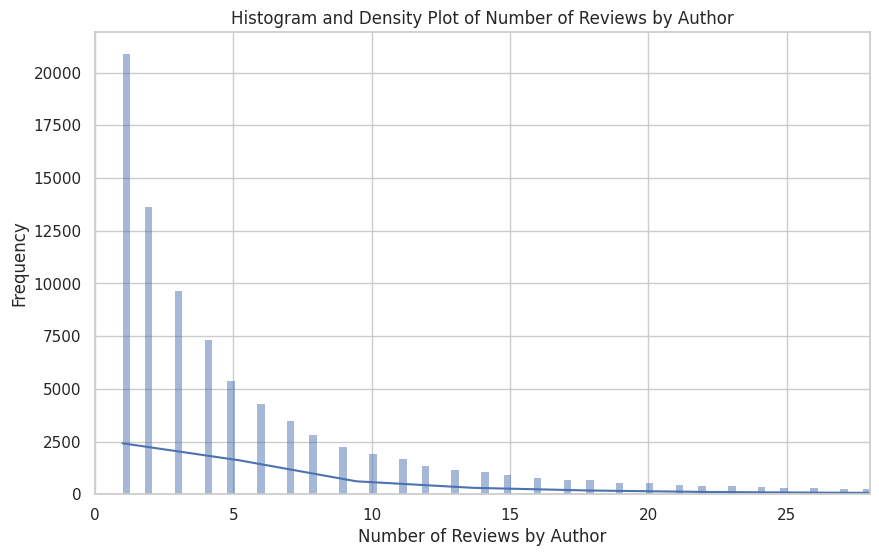

In [ ]:
# Histogram and density of author_num_reviews
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))
# Create the histogram with a density plot overlay, setting the bins to be more appropriate for the range of data
sns.histplot(author_num_reviews_df['author_num_reviews'], kde=True)  # Adjust the number of bins as necessary

# Setting the limits for the x-axis
plt.xlim(0, author_num_reviews_df['author_num_reviews'].quantile(0.95))  # Adjust the quantile as necessary
# Adding labels and title
plt.xlabel('Number of Reviews by Author')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram and Density Plot of Number of Reviews by Author')  # Title of the plot
plt.show()

In [ ]:
# author_playtime_forever
df.select("author_playtime_forever").describe().show()

+-------+-----------------------+
|summary|author_playtime_forever|
+-------+-----------------------+
|  count|                  87659|
|   mean|     23247.369294653145|
| stddev|      46756.12281239812|
|    min|                      1|
|    max|                3470649|
+-------+-----------------------+



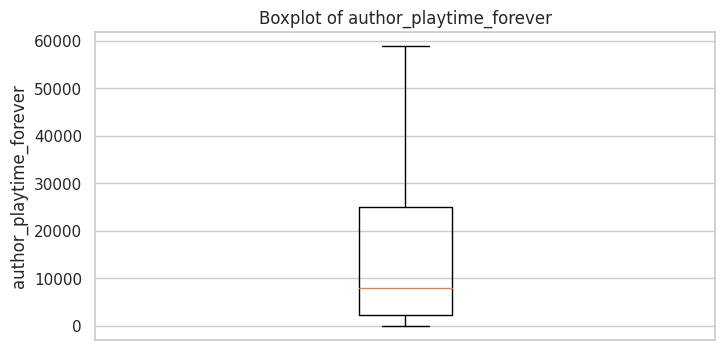

In [ ]:
# Boxplot of author_playtime_forever
author_playtime_forever_df = df.select("author_playtime_forever").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(author_playtime_forever_df['author_playtime_forever'], showfliers=False)  # Hide outliers
plt.title("Boxplot of author_playtime_forever")
plt.ylabel("author_playtime_forever")
plt.xticks([])  # Remove x-axis tick labels
plt.show()

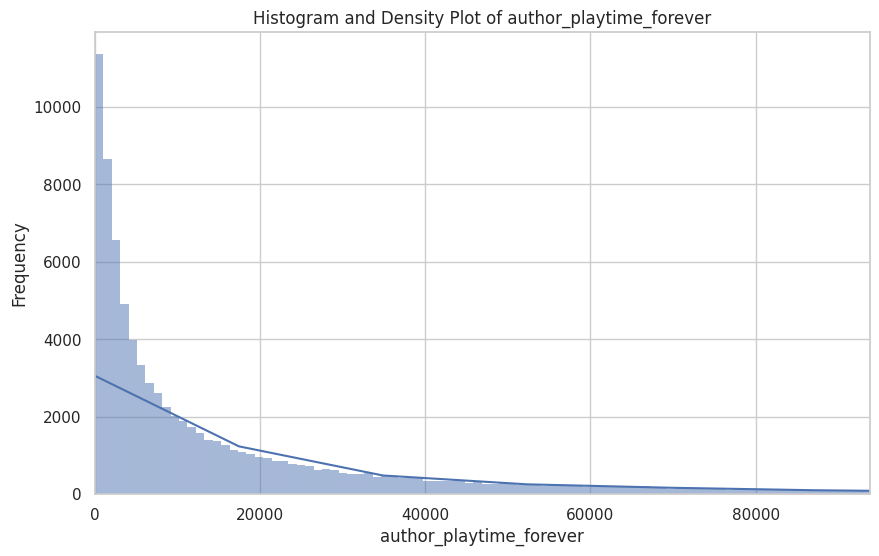

In [ ]:
# Histogram and density of author_playtime_forever
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))
# Create the histogram with a density plot overlay, setting the bins to be more appropriate for the range of data
sns.histplot(author_playtime_forever_df['author_playtime_forever'], kde=True)  # Adjust the number of bins as necessary

# Setting the limits for the x-axis
plt.xlim(0, author_playtime_forever_df['author_playtime_forever'].quantile(0.95))  # Adjust the quantile as necessary
# Adding labels and title
plt.xlabel('author_playtime_forever')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram and Density Plot of author_playtime_forever')  # Title of the plot
plt.show()

In [ ]:
# author_playtime_last_two_weeks
df.select("author_playtime_last_two_weeks").describe().show()

+-------+------------------------------+
|summary|author_playtime_last_two_weeks|
+-------+------------------------------+
|  count|                         87659|
|   mean|            226.00329686626588|
| stddev|             875.4579104099208|
|    min|                             0|
|    max|                         20001|
+-------+------------------------------+



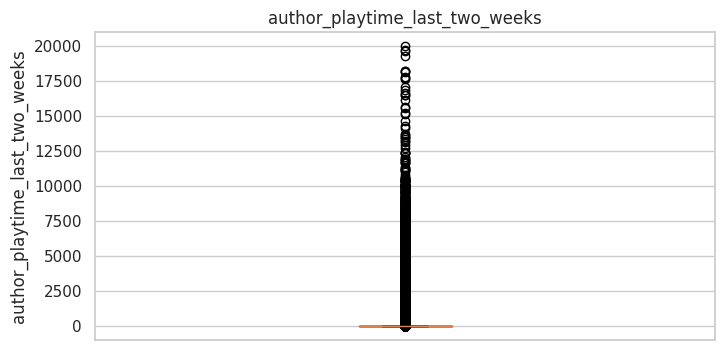

In [ ]:
# Boxplot of author_playtime_last_two_weeks
author_playtime_last_two_weeks_df = df.select("author_playtime_last_two_weeks").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(author_playtime_last_two_weeks_df['author_playtime_last_two_weeks'])
plt.title("author_playtime_last_two_weeks")
plt.ylabel("author_playtime_last_two_weeks")
plt.xticks([])  # Remove x-axis tick labels
plt.show()

In [ ]:
# author_playtime_at_review
df.select("author_playtime_at_review").describe().show()

+-------+-------------------------+
|summary|author_playtime_at_review|
+-------+-------------------------+
|  count|                    87659|
|   mean|       13333.953216440981|
| stddev|         32303.5937034837|
|    min|                        1|
|    max|                  3228103|
+-------+-------------------------+



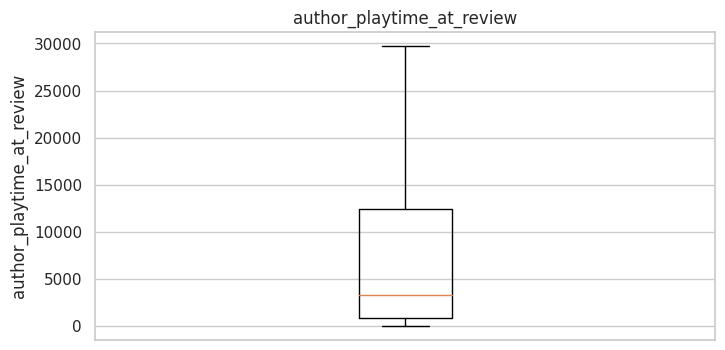

In [ ]:
# Boxplot of author_playtime_at_review
author_playtime_at_review_df = df.select("author_playtime_at_review").toPandas()
plt.figure(figsize=(8, 4))
plt.boxplot(author_playtime_at_review_df['author_playtime_at_review'], showfliers=False)
plt.title("author_playtime_at_review")
plt.ylabel("author_playtime_at_review")
plt.xticks([])  # Remove x-axis tick labels
plt.show()

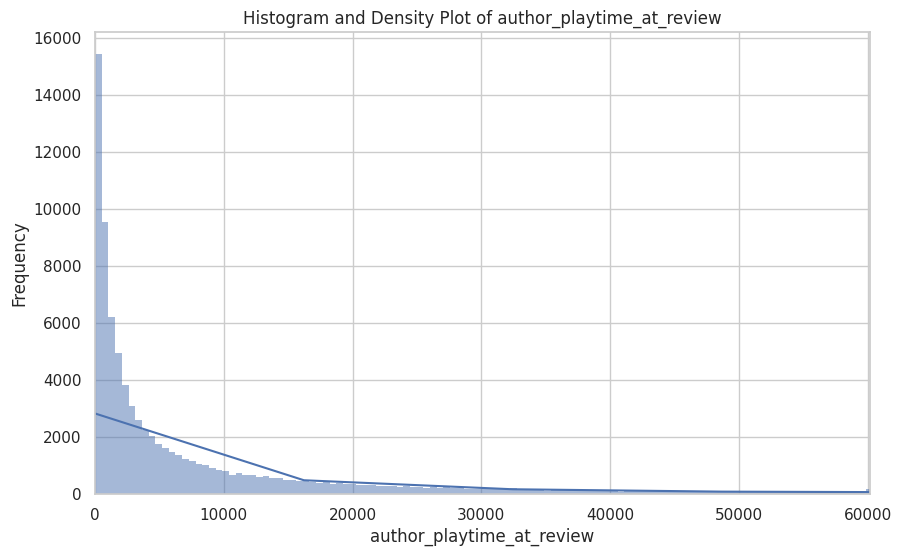

In [ ]:
# Histogram and density of author_playtime_at_review
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
# Set the size of the figure
plt.figure(figsize=(10, 6))
# Create the histogram with a density plot overlay, setting the bins to be more appropriate for the range of data
sns.histplot(author_playtime_at_review_df['author_playtime_at_review'], kde=True)  # Adjust the number of bins as necessary

# Setting the limits for the x-axis
plt.xlim(0, author_playtime_at_review_df['author_playtime_at_review'].quantile(0.95))  # Adjust the quantile as necessary
# Adding labels and title
plt.xlabel('author_playtime_at_review')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram and Density Plot of author_playtime_at_review')  # Title of the plot
plt.show()

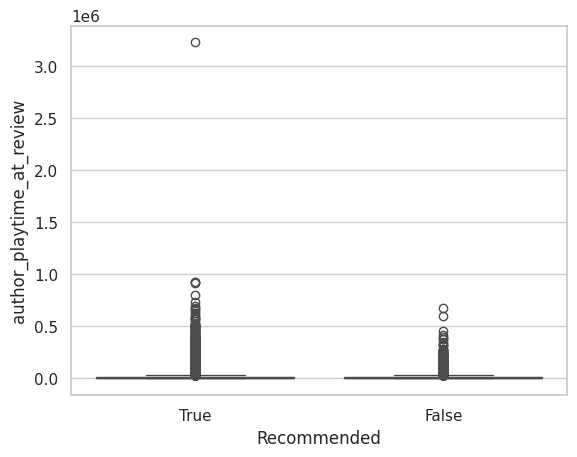

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data= df.select('author_playtime_at_review', 'recommended').toPandas(), x='recommended', y='author_playtime_at_review')
# Setting labels
ax.set_xlabel('Recommended')
ax.set_ylabel('author_playtime_at_review')
plt.show()

Compare Columns

In [ ]:
# app_name - author_playtime_at_review

app_playtime_stats = df.groupBy("app_name").agg(
    avg("author_playtime_at_review").alias("avg_playtime"),
    min("author_playtime_at_review").alias("min_playtime"),
    max("author_playtime_at_review").alias("max_playtime")
)
app_playtime_stats.show()

+--------------------+------------------+------------+------------+
|            app_name|      avg_playtime|min_playtime|max_playtime|
+--------------------+------------------+------------+------------+
|    Human: Fall Flat|             802.0|          13|        6980|
|The Witcher 3: Wi...| 5959.769630110318|           5|       95594|
|    Dead by Daylight| 12398.35667870036|           6|      275380|
|            NBA 2K18|             369.0|         344|         394|
|Sid Meier's Civil...|23575.418367346938|           5|     3228103|
|             Celeste|3883.6923076923076|         105|       34210|
|            Portal 2| 1927.377358490566|          11|       92997|
|          Cube World|             390.0|          23|         724|
|Getting Over It w...| 909.1666666666666|          36|        7276|
|PC Building Simul...|1036.5294117647059|         130|        2570|
|Wolfenstein: Youn...|             453.0|         453|         453|
|          Beat Saber| 2013.358024691358|       

In [ ]:
# app_name - author_num_reviews

# Group by `app_name` and calculate the average, minimum, and maximum playtime
app_playtime_stats = df.groupBy("app_name").agg(
    avg("author_num_reviews").alias("avg_num_reviews"),
    min("author_num_reviews").alias("min_num_reviews"),
    max("author_num_reviews").alias("max_num_reviews")
)
app_playtime_stats.show()

+--------------------+------------------+---------------+---------------+
|            app_name|   avg_num_reviews|min_num_reviews|max_num_reviews|
+--------------------+------------------+---------------+---------------+
|    Human: Fall Flat|14.414634146341463|              1|            142|
|The Witcher 3: Wi...| 9.064892926670993|              1|            402|
|    Dead by Daylight| 7.371841155234657|              1|            227|
|            NBA 2K18|               4.0|              1|              7|
|Sid Meier's Civil...|  9.73469387755102|              1|            311|
|             Celeste| 5.538461538461538|              1|             14|
|            Portal 2|13.189937106918238|              1|            354|
|          Cube World|              13.6|              2|             44|
|Getting Over It w...|13.722222222222221|              1|             72|
|PC Building Simul...|14.705882352941176|              1|             97|
|Wolfenstein: Youn...|              12

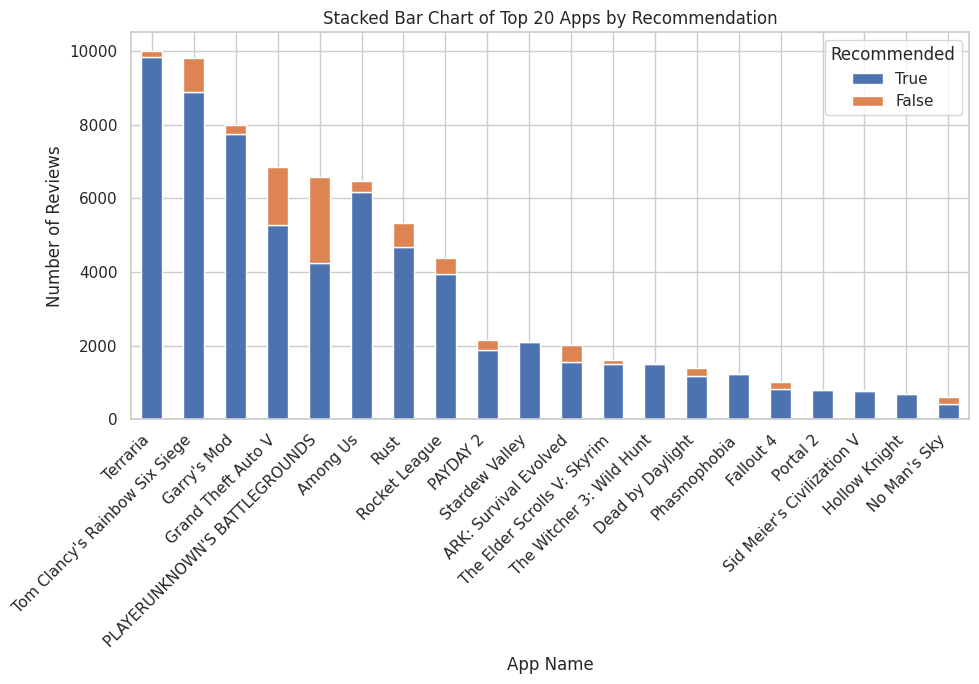

In [ ]:
# Stacked Bar Chart of Recommendations by App

# Calculate the total number of reviews for each app
total_reviews_per_app = df.groupBy("app_name").count()

# Find the top 20 apps with the most reviews
top_20_apps = total_reviews_per_app.orderBy("count", ascending=False).limit(20)

# Join the top 20 apps DataFrame with the original DataFrame to filter the data
top_20_df = top_20_apps.join(df, "app_name")

# Now group by 'app_name' and 'recommended', then count the number of reviews
reviews_by_app_recommendation = top_20_df.groupBy('app_name', 'recommended').count()

# Pivot the 'recommended' column to create a separate column for each recommendation status
pivot_df = reviews_by_app_recommendation.groupBy('app_name').pivot('recommended').sum('count')

# Fill any missing values with 0
pivot_df_filled = pivot_df.na.fill(0)

# Convert to Pandas DataFrame for plotting
pandas_df = pivot_df_filled.toPandas()
pandas_df.set_index('app_name', inplace=True)

pandas_df['total_reviews'] = pandas_df['True'] + pandas_df['False']
pandas_df_sorted = pandas_df.sort_values(by='total_reviews', ascending=False)

pandas_df_sorted[['True', 'False']].plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Stacked Bar Chart of Top 20 Apps by Recommendation')
plt.xlabel('App Name')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Recommended', loc='upper right')
plt.tight_layout()
plt.show()

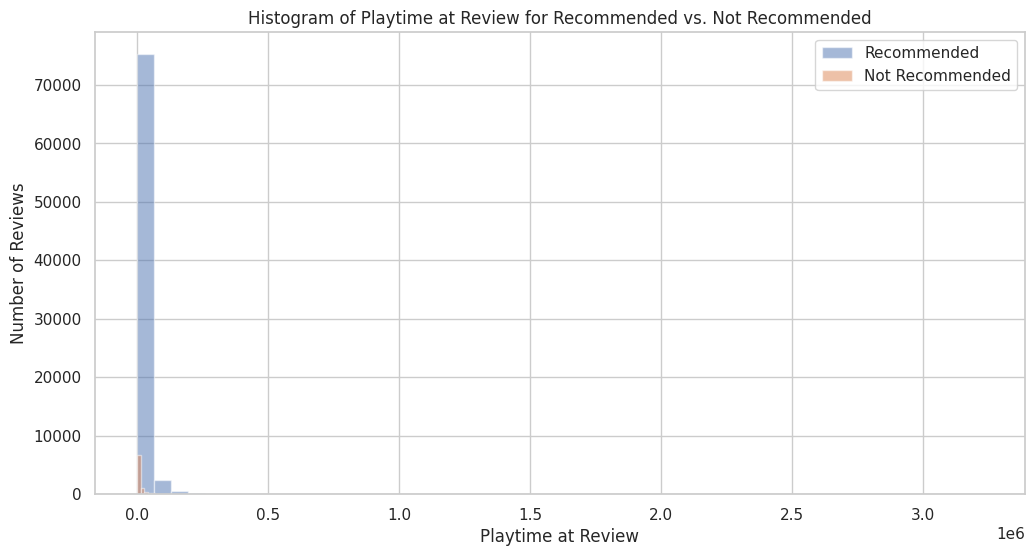

In [ ]:
# Histogram of Playtime for Recommended vs Not Recommended

recommended_df = df.filter(df['recommended'] == 'True')
not_recommended_df = df.filter(df['recommended'] == 'False')

recommended_pd = recommended_df.select('author_playtime_at_review').toPandas()
not_recommended_pd = not_recommended_df.select('author_playtime_at_review').toPandas()

plt.figure(figsize=(12, 6))

# histogram for recommended reviews
plt.hist(recommended_pd['author_playtime_at_review'], bins=50, alpha=0.5, label='Recommended')

# histogram for not recommended reviews
plt.hist(not_recommended_pd['author_playtime_at_review'], bins=50, alpha=0.5, label='Not Recommended')


plt.xlabel('Playtime at Review')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Playtime at Review for Recommended vs. Not Recommended')
plt.legend()
plt.show()

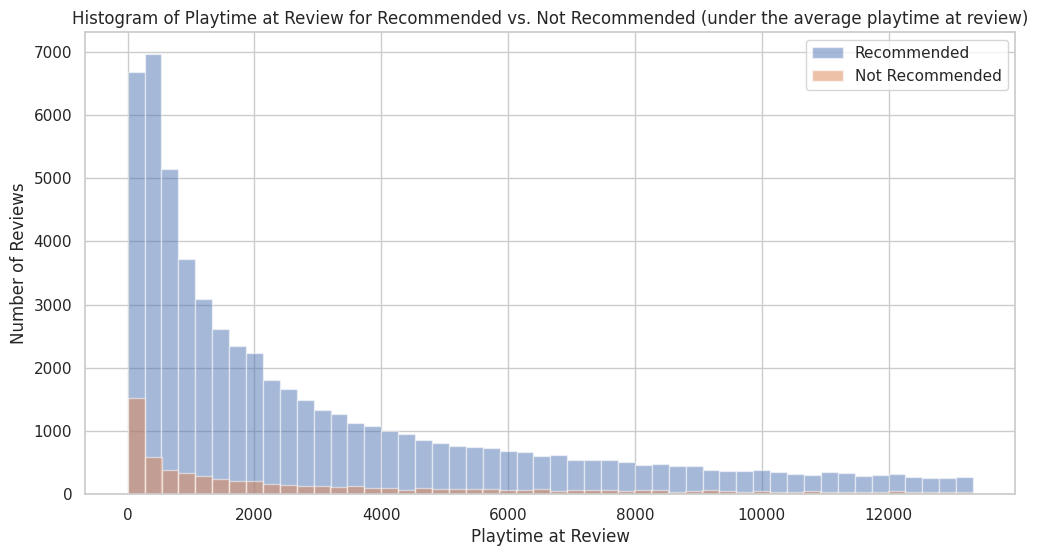

In [ ]:
# Histogram of Playtime for Recommended vs Not Recommended
# filtered

average_playtime = df.agg(avg("author_playtime_at_review")) #13333.953216440981
threshold = average_playtime.collect()[0]

recommended_filtered = recommended_pd[recommended_pd['author_playtime_at_review'] <= threshold]
not_recommended_filtered = not_recommended_pd[not_recommended_pd['author_playtime_at_review'] <= threshold]

plt.figure(figsize=(12, 6))
# hist for filtered recommended
plt.hist(recommended_filtered['author_playtime_at_review'], bins=50, alpha=0.5, label='Recommended')
# hist for filtered not recommended
plt.hist(not_recommended_filtered['author_playtime_at_review'], bins=50, alpha=0.5, label='Not Recommended')
plt.xlabel('Playtime at Review')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Playtime at Review for Recommended vs. Not Recommended (under the average playtime at review)')
plt.legend()
plt.show()

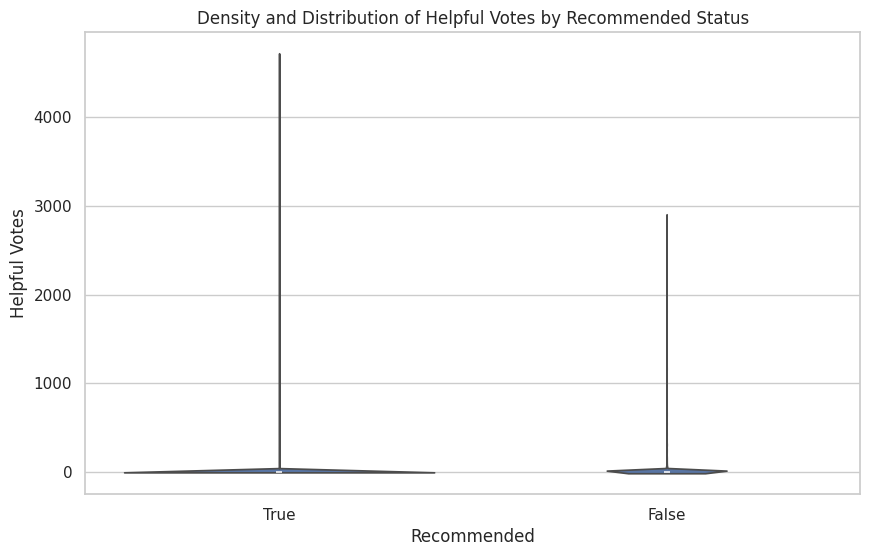

In [ ]:
# recommended - votes_helpful
pandas_df = df.select('recommended','votes_helpful').toPandas()
plt.figure(figsize=(10, 6))
sns.violinplot(x='recommended', y='votes_helpful', data=pandas_df)
plt.title('Density and Distribution of Helpful Votes by Recommended Status')
plt.xlabel('Recommended')
plt.ylabel('Helpful Votes')
plt.show()

<Figure size 1000x600 with 0 Axes>

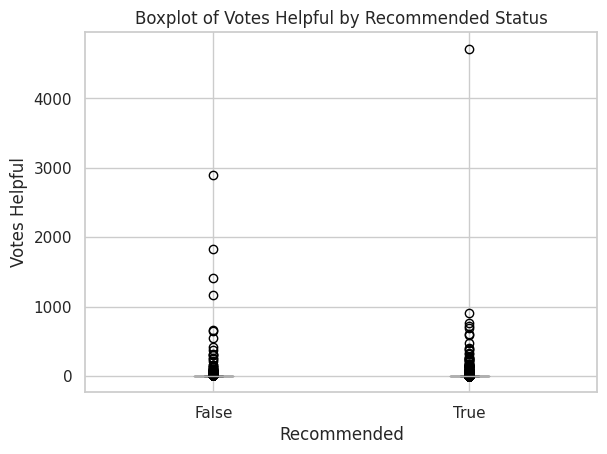

In [ ]:
votes_helpful_df = df.select("votes_helpful", "recommended")
votes_helpful_pd = votes_helpful_df.toPandas()

# Plot for votes_helpful
plt.figure(figsize=(10, 6))
votes_helpful_pd.boxplot(by='recommended', column=['votes_helpful'])
plt.title('Boxplot of Votes Helpful by Recommended Status')
plt.suptitle('')  # Suppress the default title to clean up the plot
plt.xlabel('Recommended')
plt.ylabel('Votes Helpful')
plt.show()

<Figure size 1000x600 with 0 Axes>

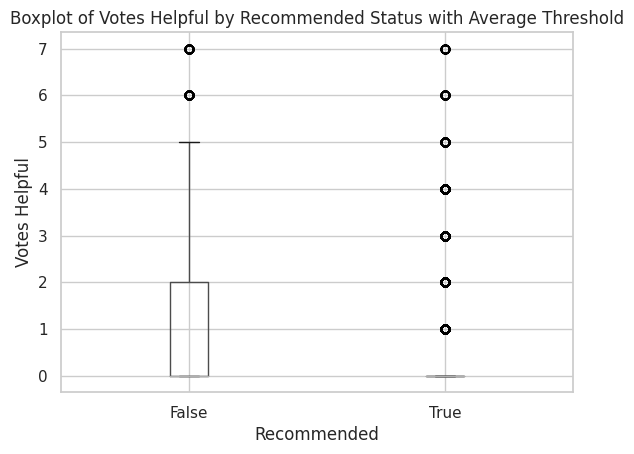

In [ ]:
# recommended- votes_helpful me threshold

average_votes_helpful_filtered = df.filter(col("votes_helpful") <= 7)
average_votes_helpful_filtered_pd = average_votes_helpful_filtered.toPandas()

plt.figure(figsize=(10, 6))
average_votes_helpful_filtered_pd.boxplot(by='recommended', column=['votes_helpful'])
plt.title('Boxplot of Votes Helpful by Recommended Status with Average Threshold')
plt.suptitle('')
plt.xlabel('Recommended')
plt.ylabel('Votes Helpful')
plt.show()

<Figure size 1000x600 with 0 Axes>

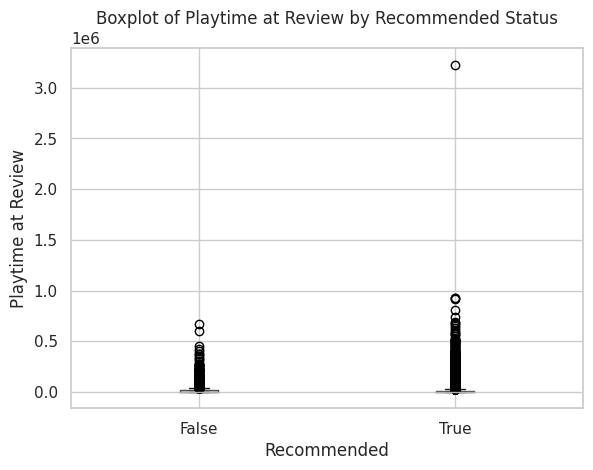

In [ ]:
# author playtime me recommended

playtime_df = df.select("author_playtime_at_review", "recommended")
playtime_pd = playtime_df.toPandas()

# Plot for author_playtime_at_review
plt.figure(figsize=(10, 6))
playtime_pd.boxplot(by='recommended', column=['author_playtime_at_review'])
plt.title('Boxplot of Playtime at Review by Recommended Status')
plt.suptitle('')
plt.xlabel('Recommended')
plt.ylabel('Playtime at Review')
plt.show()

<Figure size 1000x600 with 0 Axes>

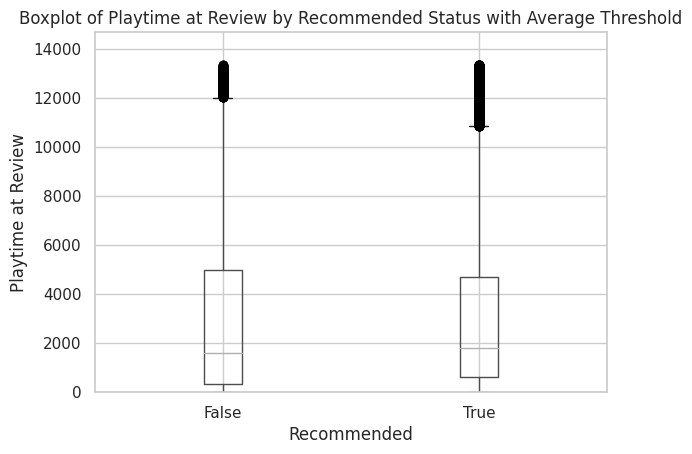

In [ ]:
# author playtime me recommended me threshold to average tou author playtime at review

average_playtime_row = df.agg(avg("author_playtime_at_review").alias("avg_playtime")).first()
average_playtime = average_playtime_row['avg_playtime']

author_playtime_filtered = df.filter(col("author_playtime_at_review") <= average_playtime)

author_playtime_filtered_pd = author_playtime_filtered.toPandas()

plt.figure(figsize=(10, 6))
author_playtime_filtered_pd.boxplot(by='recommended', column=['author_playtime_at_review'])
plt.title('Boxplot of Playtime at Review by Recommended Status with Average Threshold')
plt.suptitle('')
plt.xlabel('Recommended')
plt.ylabel('Playtime at Review')
plt.ylim(0, average_playtime * 1.1)  # Set the y-axis limit to a bit above the average to better visualize the distribution
plt.show()

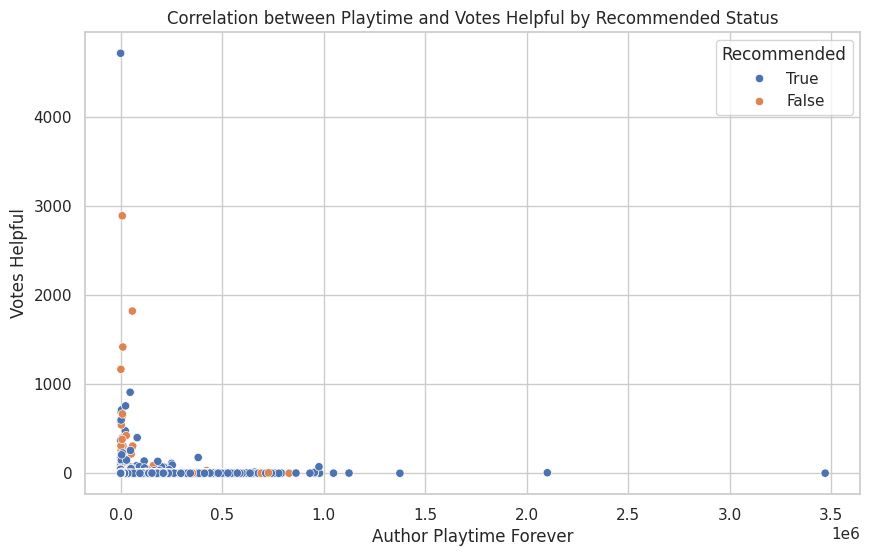

In [ ]:
# author playtime forever - votes_helpful vs recommended

playtime_votes_df = df.select('author_playtime_forever', 'votes_helpful', 'recommended').toPandas()

# Plotting the first scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=playtime_votes_df, x='author_playtime_forever', y='votes_helpful', hue='recommended')
plt.title('Correlation between Playtime and Votes Helpful by Recommended Status')
plt.xlabel('Author Playtime Forever')
plt.ylabel('Votes Helpful')
plt.legend(title='Recommended')
plt.show()

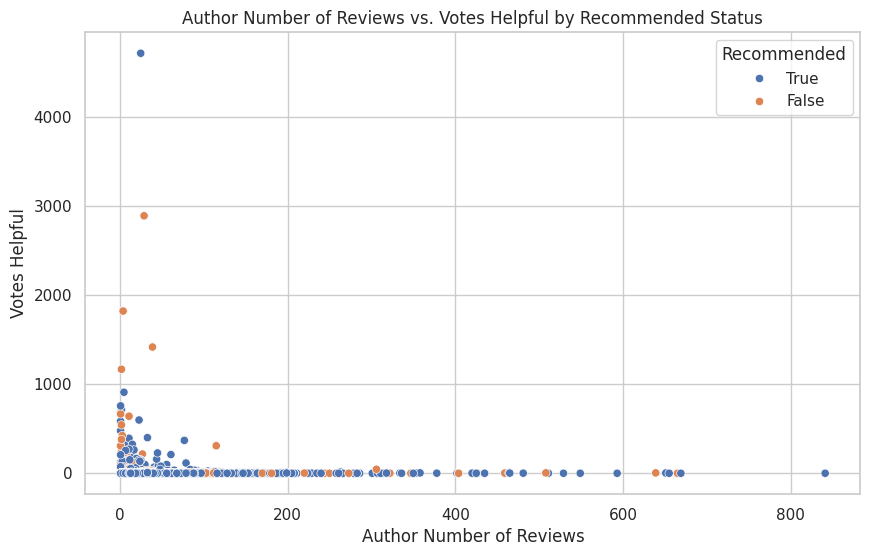

In [ ]:
# author num reviews - votes_helpful vs recommended

reviews_votes_df = df.select('author_num_reviews', 'votes_helpful', 'recommended').toPandas()

# Plotting the second scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews_votes_df, x='author_num_reviews', y='votes_helpful', hue='recommended')
plt.title('Author Number of Reviews vs. Votes Helpful by Recommended Status')
plt.xlabel('Author Number of Reviews')
plt.ylabel('Votes Helpful')
plt.legend(title='Recommended')
plt.show()

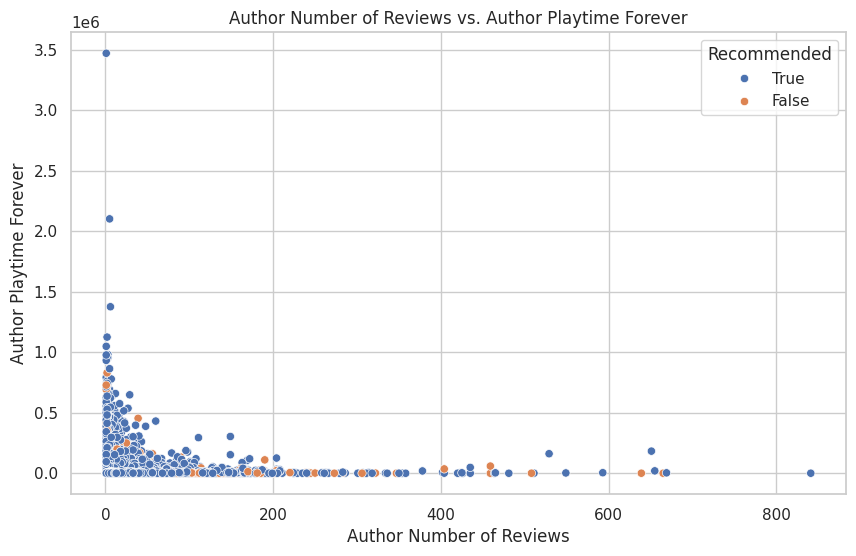

In [ ]:
# author number of reviews - author playtime_forever vs recommended

review_playtime_df = df.select('author_num_reviews', 'author_playtime_forever', 'recommended').toPandas()

# Plotting the second scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=review_playtime_df, x='author_num_reviews', y='author_playtime_forever', hue='recommended')
plt.title('Author Number of Reviews vs. Author Playtime Forever')
plt.xlabel('Author Number of Reviews')
plt.ylabel('Author Playtime Forever')
plt.legend(title='Recommended')
plt.show()

## Correlation Matrix

In [ ]:
# List of column names that you want to include in the correlation matrix
column_names = ['recommended_numeric', 'votes_helpful', 'weighted_vote_score','comment_count','steam_purchase_numeric',
                'received_for_free_numeric','written_during_early_access_numeric','author_num_games_owned','author_num_reviews',
                'author_playtime_forever','author_playtime_last_two_weeks','author_playtime_at_review','author_last_played']

# Assemble the features into a single vector column, handling nulls by keeping them (they become 0 in the vector)
assembler = VectorAssembler(inputCols=column_names, outputCol="features", handleInvalid="keep")
df_vector = assembler.transform(df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Transform this DenseMatrix to a DataFrame
correlation_array = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_array, index=column_names, columns=column_names)
print(correlation_df)

                                     recommended_numeric  votes_helpful  \
recommended_numeric                             1.000000      -0.033946   
votes_helpful                                  -0.033946       1.000000   
weighted_vote_score                            -0.221946       0.070558   
comment_count                                  -0.057662       0.681636   
steam_purchase_numeric                          0.012769      -0.002124   
received_for_free_numeric                       0.019254      -0.001072   
written_during_early_access_numeric            -0.057561       0.005941   
author_num_games_owned                         -0.065657       0.037616   
author_num_reviews                             -0.058559       0.013088   
author_playtime_forever                         0.016632       0.003123   
author_playtime_last_two_weeks                  0.035686      -0.003076   
author_playtime_at_review                      -0.000128       0.001509   
author_last_played       

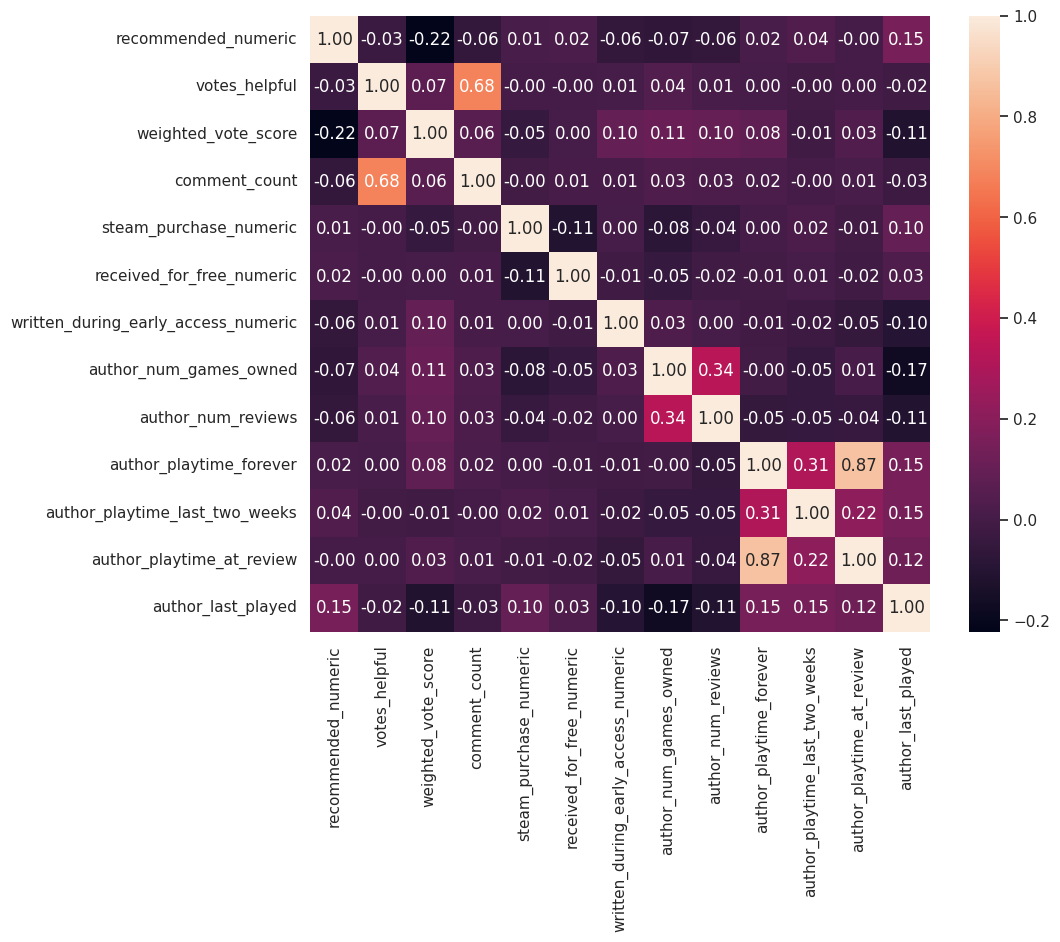

In [ ]:
# Heatmap

# Set the figure size
plt.figure(figsize=(10, 8))
# Create the heatmap
sns.heatmap(correlation_df, annot=True, fmt=".2f")
plt.show()

We can see that author_playtime_forever is highly correlated with author_playtime_at review and comment_count is highly correlated with votes_helpful.

## Feature Selection

Here, we use Random Forest to find the importance of features

Test Error = 0.221493
Feature Importances: [('weighted_vote_score', 0.48358142702085516), ('votes_helpful', 0.28327094141449266), ('author_playtime_forever', 0.09391130005223668), ('author_last_played', 0.07604940900032321), ('author_playtime_at_review', 0.027116032715952792), ('comment_count', 0.017622397075593235), ('steam_purchase_numeric', 0.004956000984261189), ('author_playtime_last_two_weeks', 0.004809826722719746), ('author_num_games_owned', 0.0034639181655476705), ('written_during_early_access_numeric', 0.002326061730986238), ('author_num_reviews', 0.0019413763159170812), ('received_for_free_numeric', 0.0009513088011141811)]


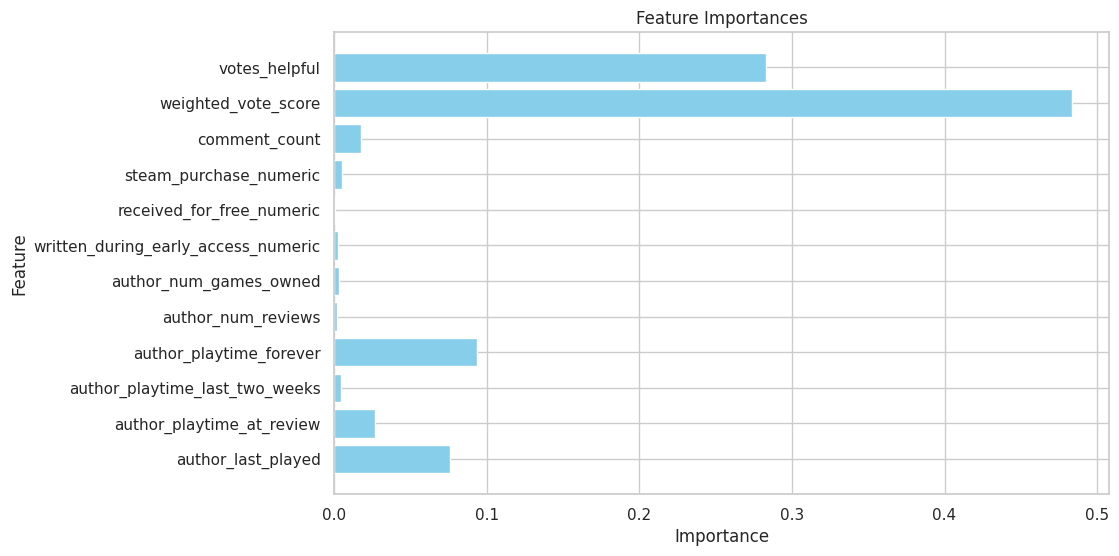

In [ ]:
feature_columns = ['votes_helpful', 'weighted_vote_score','comment_count','steam_purchase_numeric','received_for_free_numeric',
                   'written_during_early_access_numeric','author_num_games_owned','author_num_reviews','author_playtime_forever',
                   'author_playtime_last_two_weeks','author_playtime_at_review','author_last_played']

# Index the label column
labelIndexer = StringIndexer(inputCol="recommended", outputCol="indexedLabel").fit(df)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the classifier
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10)

# Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

# Create a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, rf, labelConverter])

# Fit the model
model = pipeline.fit(df)

# Make predictions
predictions = model.transform(df)

# Select (prediction, true label) and compute test error.
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

# Access feature importances
rfModel = model.stages[2]  # Assuming the RandomForest model is the third stage in the pipeline
importances = rfModel.featureImportances
x = list(zip(feature_columns, importances))
sorted_features = sorted(x, key=lambda x: x[1], reverse=True)

print("Feature Importances:", sorted_features)

# Extract feature names
feature_names = feature_columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances.toArray().tolist(), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

We can observe that the two most important features are the weighted_vote_score, the votes_helpful and author_playtime_forever.

Here, we try to find the most important features using Decision Tree

Test Error = 0.742768
Feature Importances: [('weighted_vote_score', 0.4869080385709438), ('votes_helpful', 0.46149977098491984), ('author_playtime_forever', 0.04331600284661133), ('author_last_played', 0.006222468030294554), ('author_num_reviews', 0.002053719567230452), ('comment_count', 0.0), ('steam_purchase_numeric', 0.0), ('received_for_free_numeric', 0.0), ('written_during_early_access_numeric', 0.0), ('author_num_games_owned', 0.0), ('author_playtime_last_two_weeks', 0.0), ('author_playtime_at_review', 0.0)]


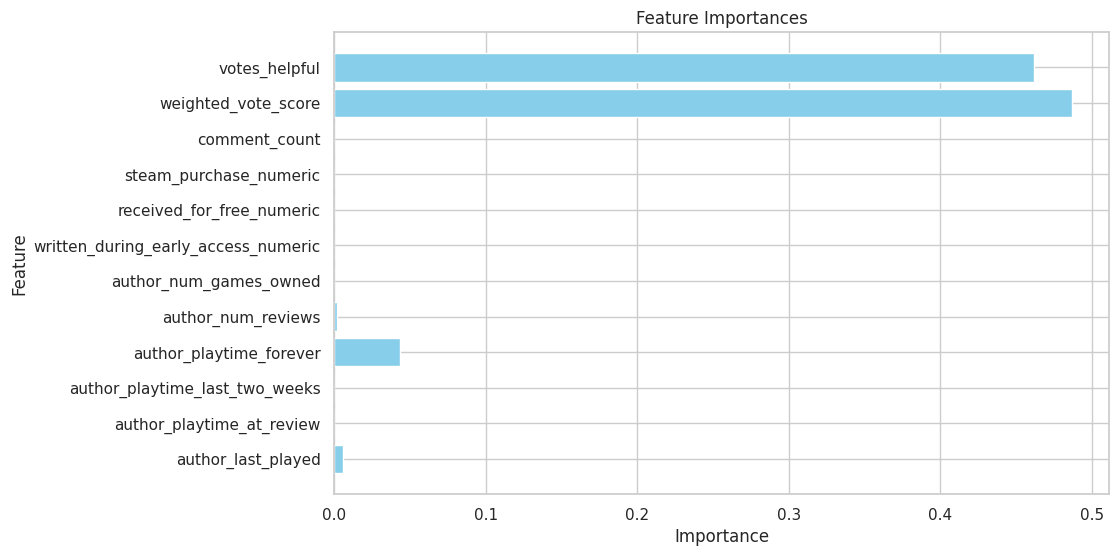

In [ ]:
labelIndexer = StringIndexer(inputCol="recommended", outputCol="indexedLabel").fit(df)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the classifier
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

# Create a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, dt, labelConverter])

# Fit the model
model = pipeline.fit(df)

# Make predictions
predictions = model.transform(df)

# Select (prediction, true label) and compute test error.
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

# Access feature importances
dtModel = model.stages[2]  # Assuming the DecisionTree model is the third stage in the pipeline
importances = dtModel.featureImportances
x = list(zip(feature_columns, importances))
sorted_features = sorted(x, key=lambda x: x[1], reverse=True)

print("Feature Importances:", sorted_features)

# Extract feature names
feature_names = feature_columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances.toArray().tolist(), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

Again, we can see that the 2 most important features are the weighted_vote_score, the votes_helpful and author_playtime_forever.

Here, we try to perform feature selection using the Gradient Boosting Algorithm

Test Error = 0.182692
Feature Importances: [('weighted_vote_score', 0.2968101918407471), ('votes_helpful', 0.23425226773757765), ('author_playtime_forever', 0.12384179045859661), ('author_last_played', 0.12266375299811921), ('author_playtime_at_review', 0.09683046129043717), ('comment_count', 0.03540180733270473), ('author_num_reviews', 0.029227538105703738), ('author_num_games_owned', 0.02216107680574087), ('steam_purchase_numeric', 0.020717463508920047), ('written_during_early_access_numeric', 0.01622598343414128), ('author_playtime_last_two_weeks', 0.0018676664873116832), ('received_for_free_numeric', 0.0)]


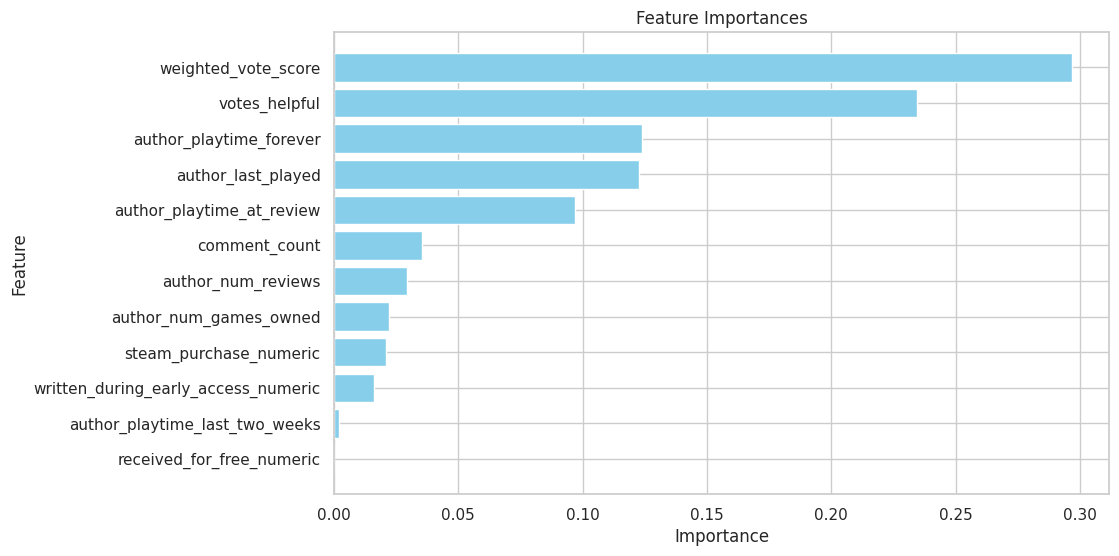

In [ ]:
labelIndexer = StringIndexer(inputCol="recommended", outputCol="indexedLabel").fit(df)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the classifier
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=10)

# Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

# Create a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, gbt, labelConverter])

# Fit the model
model = pipeline.fit(df)

# Make predictions
predictions = model.transform(df)

# Select (prediction, true label) and compute test error.
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

# Access feature importances
gbtModel = model.stages[2]  # Assuming the GBT model is the third stage in the pipeline
importances = gbtModel.featureImportances
sorted_features = sorted(list(zip(feature_columns, importances.toArray())), key=lambda x: x[1], reverse=True)

print("Feature Importances:", sorted_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in sorted_features], [f[1] for f in sorted_features], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Again, we can observe that the 2 most important features are the weighted_vote_score, the votes_helpful and author_playtime_forever.

We decided to fit our model using these 3 features, because they were the top 3 features according to the feature selection methods we tried before.
The important features are : 'weighted_vote_score', 'votes_helpful',
 'author_playtime_forever'.

In [ ]:
feature_columns = ['votes_helpful', 'weighted_vote_score','author_playtime_forever']

## Binary Classification

Functions

In [ ]:
# Function for confusion matrix
def plot_confusion_matrix_and_metrics(predictions):
    """
    Function to plot confusion matrix and calculate metrics using PySpark DataFrame operations.
    predictions: a PySpark DataFrame with 'prediction' and 'recommended_numeric' columns
    """

    confusion_matrix = predictions.groupBy('prediction', 'recommended_numeric').count().toPandas()
    TP = confusion_matrix[(confusion_matrix['prediction'] == 1) & (confusion_matrix['recommended_numeric'] == 1)]['count'].sum()
    TN = confusion_matrix[(confusion_matrix['prediction'] == 0) & (confusion_matrix['recommended_numeric'] == 0)]['count'].sum()
    FP = confusion_matrix[(confusion_matrix['prediction'] == 1) & (confusion_matrix['recommended_numeric'] == 0)]['count'].sum()
    FN = confusion_matrix[(confusion_matrix['prediction'] == 0) & (confusion_matrix['recommended_numeric'] == 1)]['count'].sum()

    # Creating the confusion matrix
    confusion_matrix = [[TN, FP],
                        [FN, TP]]

    # Plotting the confusion matrix using seaborn
    sns.set()
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Reds')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Function for Precision Recall curve
def plot_precision_recall_curve(predictions):
    """
    Plot a Precision-Recall curve using predictions from a PySpark model.
    predictions: PySpark DataFrame with 'probability' and 'recommended_numeric' columns
    """
    # Collect data to the driver node
    data_collected = predictions.select('probability', 'recommended_numeric').collect()

    # Extract probability of positive class and true labels
    y_scores = [prob[1] for prob, _ in data_collected]
    y_true = [label for _, label in data_collected]

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

Split of the dataset

In [ ]:
# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

# Show the count of observations for each dataset
print(f"Training Dataset Count: {trainingData.count()}")
print(f"Test Dataset Count: {testData.count()}")

Training Dataset Count: 70272
Test Dataset Count: 17387


#### Master Classification Engine

Here, we use 3 algorithms for the binary classification. The 3 algorithms are: Logistic Regression, RandomForestClassifier and DecisionTreeClassifer.
For each algorithm we plot the confusion matrix and the Precision-Recall curve. We also save the metrics in the metrics list and we print them in the next cell.

Classifier: LogisticRegression


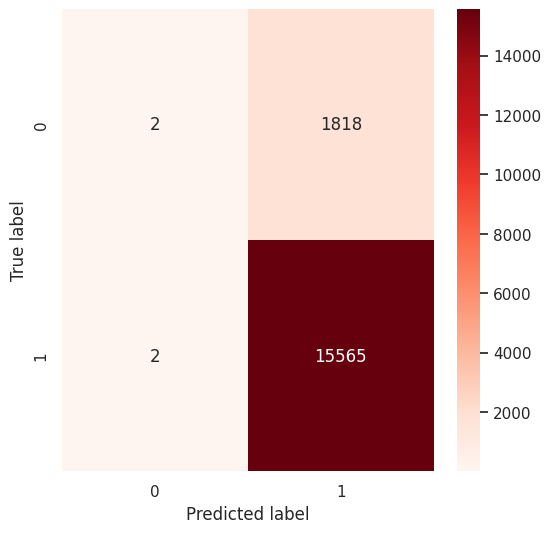

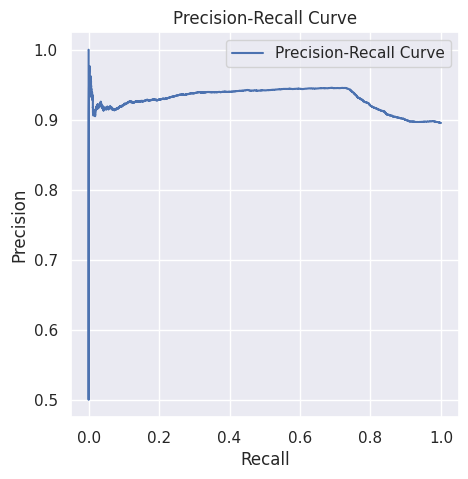

--------------------------------------------------------------------------------
Classifier: RandomForestClassifier


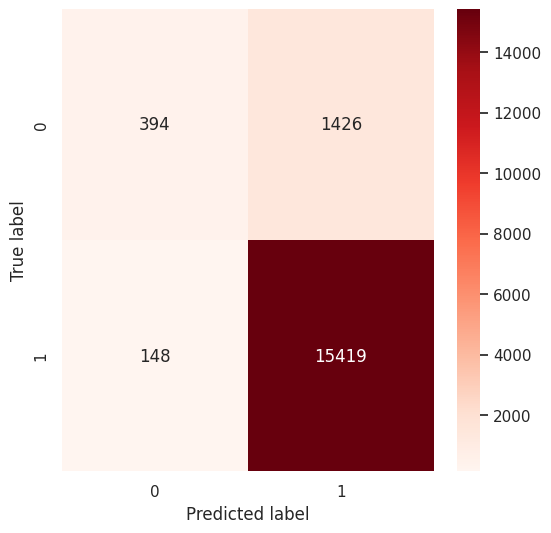

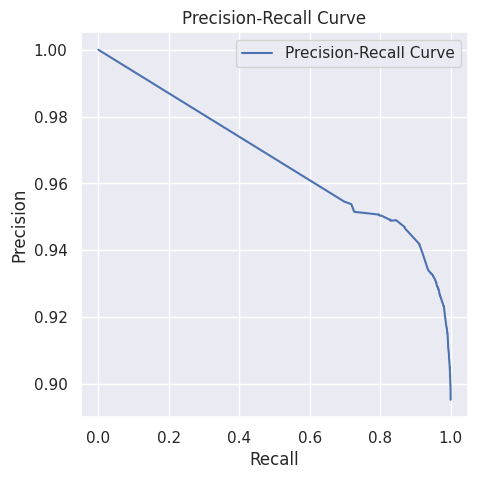

--------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier


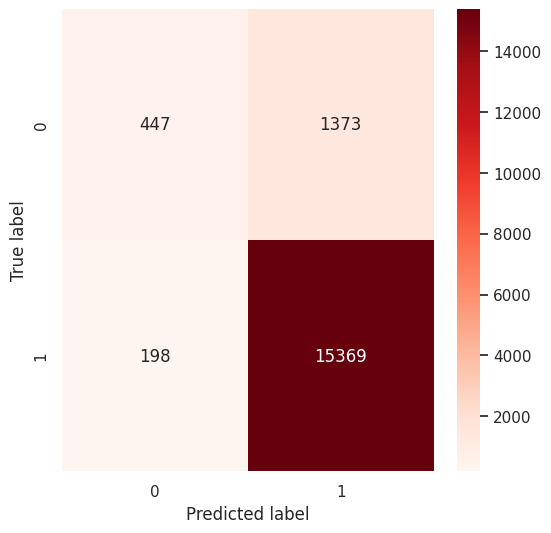

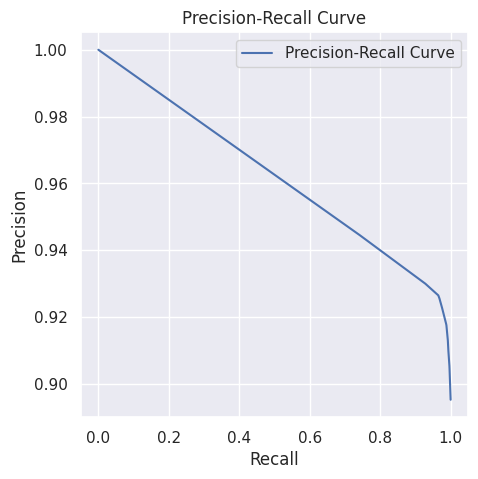

--------------------------------------------------------------------------------


In [ ]:
# Empty list to store results
metrics_list = []

# Before fitting the pipeline, check if 'prediction' or 'rawPrediction' columns exist and drop them if they do
columns_to_drop = ['prediction', 'rawPrediction', 'probability']
for col_name in columns_to_drop:
    if col_name in trainingData.columns:
        trainingData = trainingData.drop(col_name)
    if col_name in testData.columns:
        testData = testData.drop(col_name)

# Assemble features into a single vector column
featureIndexer = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define classifiers
classifiers = [
    LogisticRegression(labelCol="recommended_numeric", featuresCol="features"),
    RandomForestClassifier(labelCol="recommended_numeric", featuresCol="features"),
    DecisionTreeClassifier(labelCol="recommended_numeric", featuresCol="features")
]

# Train and evaluate classifiers
for classifier in classifiers:
    # Chain indexers and classifier in a Pipeline
    pipeline = Pipeline(stages=[featureIndexer, classifier])

    # Train model. This also runs the indexers.
    model = pipeline.fit(trainingData)

    # Make predictions.
    predictions = model.transform(testData)

    # Show metrics
    binaryEvaluator = BinaryClassificationEvaluator(labelCol="recommended_numeric", rawPredictionCol="rawPrediction")
    multiclassEvaluator = MulticlassClassificationEvaluator(labelCol="recommended_numeric", predictionCol="prediction")

    # Compute metrics
    auc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderROC"})
    auprc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderPR"})
    precision = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "precisionByLabel"})
    recall = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "recallByLabel"})
    accuracy = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "accuracy"})
    f1 = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "f1"})

    # Append metrics to the list
    metrics_list.append((classifier.__class__.__name__, accuracy, f1, precision, recall, auc, auprc))

    print(f"Classifier: {classifier.__class__.__name__}")

    # Plot confusion matrix (using the previously defined function)
    plot_confusion_matrix_and_metrics(predictions)
    print("\n")
    # Plot the Precision Recall curve (using the previously defined function)
    plot_precision_recall_curve(predictions)
    print("-" * 80)

#### Classification Model Performance Evaluation

In [ ]:
# Convert metrics list to DataFrame
metrics_df = spark.createDataFrame(metrics_list, ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "AUPRC"])

# Convert to Pandas DataFrame
pandas_metrics_df = metrics_df.toPandas()

# Sort by F1 score
pandas_metrics_df.sort_values(by="F1 Score", ascending=False, inplace=True)

# Display Pandas DataFrame
print("\n*------------------------------ CLASSIFICATION MODEL PERFORMANCE EVALUATION ---------------------*\n")
print(pandas_metrics_df)


*------------------------------ CLASSIFICATION MODEL PERFORMANCE EVALUATION ---------------------*

                    Model  Accuracy  Precision    Recall  F1 Score       AUC  \
2  DecisionTreeClassifier  0.909645   0.889753  0.693023  0.245604  0.721529   
1  RandomForestClassifier  0.909473   0.886767  0.726937  0.216484  0.766184   
0      LogisticRegression  0.895324   0.846100  0.500000  0.001099  0.657500   

      AUPRC  
2  0.941593  
1  0.951174  
0  0.929292  


As we mentioned before, our response variable is very imbalanced, so here we created class weights to solve this problem and try to improve the metric's scores. The F1 scores which is more reliable when we deal with imbalanced response are very low. It is important for us to predict better the minority class which is the 'not recommended'.

In [ ]:
from pyspark.sql import functions as F

# Calculate class counts
class_counts = df.groupBy("recommended").count()

# Calculate total count of instances
total_count = df.count()

# Calculate class weights
class_weights = class_counts.withColumn("classWeight", F.lit(total_count) / (F.col("count") * class_counts.count())).select("recommended", "classWeight")

class_weights.show()

# Join class weights with training data
trainingData = trainingData.join(class_weights, "recommended")

+-----------+------------------+
|recommended|       classWeight|
+-----------+------------------+
|      False| 4.853765227021041|
|       True|0.5574215620191023|
+-----------+------------------+



Classifier: LogisticRegression


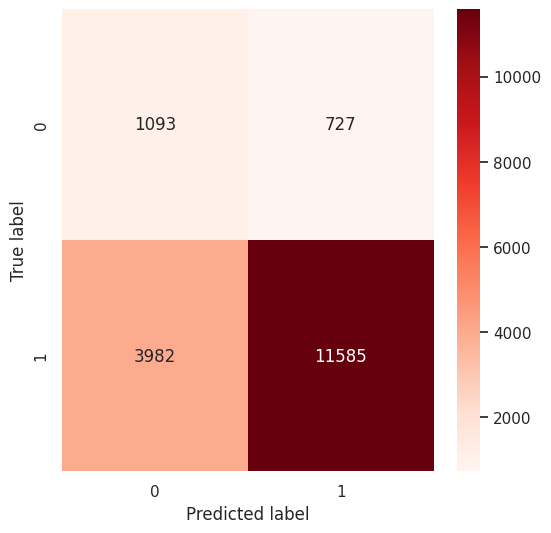

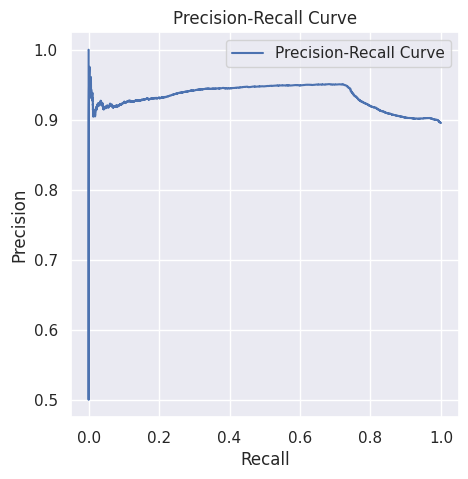

--------------------------------------------------------------------------------
Classifier: RandomForestClassifier


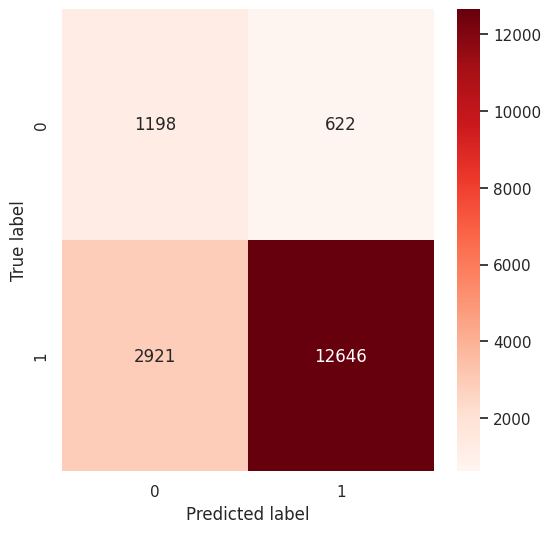

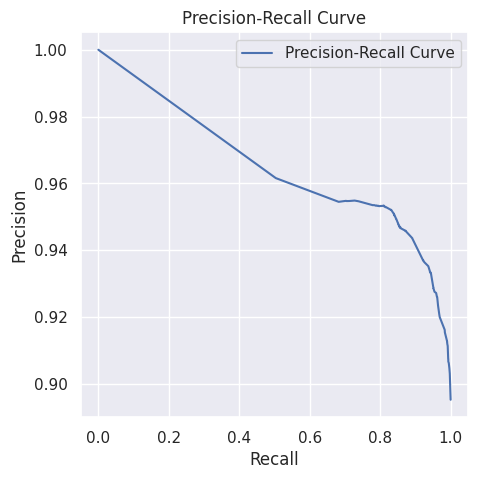

--------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier


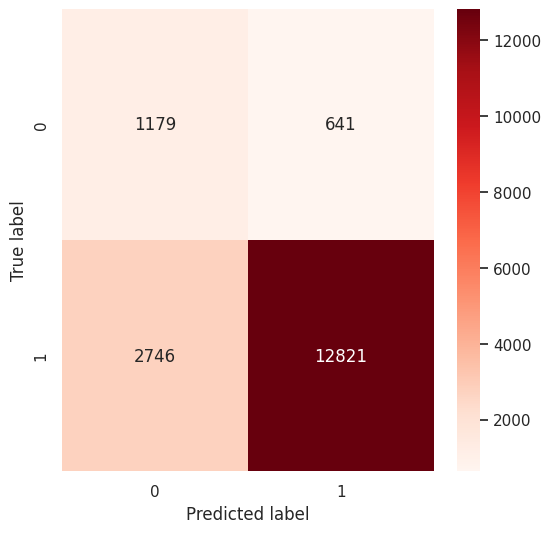

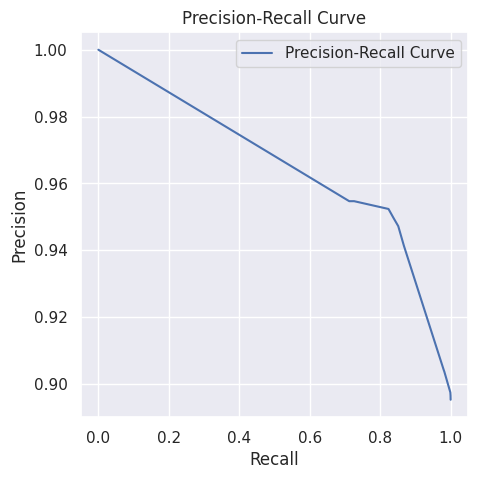

--------------------------------------------------------------------------------


In [ ]:
# Empty list to store results
metrics_list = []

# Before fitting the pipeline, check if 'prediction' or 'rawPrediction' columns exist and drop them if they do
columns_to_drop = ['prediction', 'rawPrediction', 'probability']
for col_name in columns_to_drop:
    if col_name in trainingData.columns:
        trainingData = trainingData.drop(col_name)
    if col_name in testData.columns:
        testData = testData.drop(col_name)

# Assemble features into a single vector column
featureIndexer = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define classifiers with class weights
classifiers = [
    LogisticRegression(labelCol="recommended_numeric", featuresCol="features", weightCol="classWeight"),
    RandomForestClassifier(labelCol="recommended_numeric", featuresCol="features", weightCol="classWeight"),
    DecisionTreeClassifier(labelCol="recommended_numeric", featuresCol="features", weightCol="classWeight")
]

# Train and evaluate classifiers
for classifier in classifiers:
    # Chain indexers and classifier in a Pipeline
    pipeline = Pipeline(stages=[featureIndexer, classifier])

    # Train model. This also runs the indexers.
    model = pipeline.fit(trainingData)

    # Make predictions.
    predictions = model.transform(testData)

    # Show metrics
    binaryEvaluator = BinaryClassificationEvaluator(labelCol="recommended_numeric", rawPredictionCol="rawPrediction")
    multiclassEvaluator = MulticlassClassificationEvaluator(labelCol="recommended_numeric", predictionCol="prediction")

    # Compute metrics
    auc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderROC"})
    auprc = binaryEvaluator.evaluate(predictions, {binaryEvaluator.metricName: "areaUnderPR"})
    precision = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "precisionByLabel"})
    recall = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "recallByLabel"})
    accuracy = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "accuracy"})
    f1 = multiclassEvaluator.evaluate(predictions, {multiclassEvaluator.metricName: "f1"})

    # Append metrics to the list
    metrics_list.append((classifier.__class__.__name__, accuracy, f1, precision, recall, auc, auprc))

    print(f"Classifier: {classifier.__class__.__name__}")

    # Plot confusion matrix (using the previously defined function)
    plot_confusion_matrix_and_metrics(predictions)
    print("\n")
    # Plot the Precision Recall curve (using the previously defined function)
    plot_precision_recall_curve(predictions)
    print("-" * 80)

#### Classification Model Performance Evaluation with class weights

In [ ]:
# Convert metrics list to DataFrame
metrics_df = spark.createDataFrame(metrics_list, ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "AUPRC"])

# Convert to Pandas DataFrame
pandas_metrics_df = metrics_df.toPandas()

# Sort by F1 score
pandas_metrics_df.sort_values(by="F1 Score", ascending=False, inplace=True)

# Display Pandas DataFrame
print("\n*------------------------------ CLASSIFICATION MODEL PERFORMANCE EVALUATION ---------------------*\n")
print(pandas_metrics_df)


*------------------------------ CLASSIFICATION MODEL PERFORMANCE EVALUATION ---------------------*

                    Model  Accuracy  Precision    Recall  F1 Score       AUC  \
1  RandomForestClassifier  0.796227   0.827544  0.290847  0.658242  0.777053   
2  DecisionTreeClassifier  0.805199   0.833824  0.300382  0.647802  0.698000   
0      LogisticRegression  0.729165   0.777283  0.215369  0.600549  0.674169   

      AUPRC  
1  0.955382  
2  0.943508  
0  0.932606  


We can observe that using class weights we get better F1 scores.

#### Grid Search CV and hyperparameter tuning for the 2 best models

We perform Grid Search Cross Validation for the 2 best models according to the F1 Score. We decide based on the F1 score because it works well also on imbalanced data. We perform grid search CV for the 2 best classifiers Random Forest and Decision Tree. We will use K=5 in Cross Validation.

In [ ]:
# for Grid Search CV and text analysis because it was very computationally expensive
trainingData = trainingData.sample(withReplacement=False, fraction=0.1, seed=29)
testData = testData.sample(withReplacement=False, fraction=0.1, seed=29)

In [ ]:
# Show the count of observations for each dataset
print(f"Training Dataset Count: {trainingData.count()}")
print(f"Test Dataset Count: {testData.count()}")

Training Dataset Count: 7122
Test Dataset Count: 1795


In [ ]:
# Important features
feature_columns = ['votes_helpful', 'weighted_vote_score','author_playtime_forever']

columns_to_drop = ['prediction', 'rawPrediction', 'probability']
for col_name in columns_to_drop:
    if col_name in trainingData.columns:
        trainingData = trainingData.drop(col_name)
    if col_name in testData.columns:
        testData = testData.drop(col_name)

# Assemble features into a single vector column
featureIndexer = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply the VectorAssembler transformation
trainingData2 = featureIndexer.transform(trainingData)
testData2 = featureIndexer.transform(testData)

# Create an instance of DecisionTreeClassifier, GBTClassifier and RandomForestClassifier
dt = DecisionTreeClassifier(labelCol="recommended_numeric", featuresCol="features", weightCol="classWeight")
rf = RandomForestClassifier(labelCol="recommended_numeric", featuresCol="features", weightCol="classWeight")

# Define evaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="recommended_numeric", predictionCol="prediction", metricName="accuracy")

# Define evaluator for F1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="recommended_numeric", predictionCol="prediction", metricName="f1")

# Define parameter grid for DecisionTreeClassifier
dt_param_grid  = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5]) \
    .addGrid(dt.minInstancesPerNode, [1, 3]) \
    .build()


# Define parameter grid for RandomForestClassifier
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Perform grid search cross-validation for DecisionTreeClassifier
dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_param_grid,
                       evaluator=f1_evaluator, # f1_evaluator for CV selection
                       numFolds=5)


# Perform grid search cross-validation for RandomForestClassifier
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=f1_evaluator, # f1_evaluator for CV selection
                       numFolds=5)

# Run cross-validation for DecisionTreeClassifier
dt_cv_model = dt_cv.fit(trainingData2)


# Run cross-validation for RandomForestClassifier
rf_cv_model = rf_cv.fit(trainingData2)

# Get best models
best_dt_model = dt_cv_model.bestModel
best_rf_model = rf_cv_model.bestModel

# Make predictions on test data
dt_predictions = best_dt_model.transform(testData2)
rf_predictions = best_rf_model.transform(testData2)

# Evaluate models using accuracy
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)

# Evaluate models using F1 score
dt_f1_score = f1_evaluator.evaluate(dt_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

print("DecisionTreeClassifier Accuracy: ", dt_accuracy)
print("RandomForestClassifier Accuracy: ", rf_accuracy)
print("DecisionTreeClassifier F1 Score: ", dt_f1_score)
print("RandomForestClassifier F1 Score: ", rf_f1_score)

DecisionTreeClassifier Accuracy:  0.7972144846796657
RandomForestClassifier Accuracy:  0.8534818941504179
DecisionTreeClassifier F1 Score:  0.8267402761503808
RandomForestClassifier F1 Score:  0.8620949633517168


The top 2 model's hyperparameters

In [ ]:
print(best_dt_model)
print(best_rf_model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_32a6db30055c, depth=5, numNodes=37, numClasses=2, numFeatures=3
RandomForestClassificationModel: uid=RandomForestClassifier_8bfa55a8c0f4, numTrees=20, numClasses=2, numFeatures=3


The best model (based on the F1 score) for the binary classification problem to predict if it recommended or not is using the **Random Forest Classifier** with the following hyperparameters:
- Number of trees to train: 20
- Maximum depth of the decision trees: 5 (default value)

## Text Analysis

In this part we will go over text analysis of the review column in our dataset.


In [ ]:
# Define the clean_text function using PySpark SQL functions
def clean_text(c):
    c = lower(c)
    c = regexp_replace(c, r"(https?|ftp)://[^\s]+", "")
    c = regexp_replace(c, ",", " ")
    c = regexp_replace(c, "[^a-zA-Z0-9\s]", "")
    return c

# Apply the clean_text function to create a new 'cleaned' column
df = df.withColumn('cleaned_text', clean_text(col('review')))
trainingData = trainingData.withColumn('cleaned_text', clean_text(col('review')))
testData = testData.withColumn('cleaned_text', clean_text(col('review')))
# Show the result
df.show(10)

+----+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+--------------------+
| _c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|recommended_numeric|steam_purchase_numeric|received_for_free_numeri

After cleaning our text in the review column, our next step is to create the pipeline.

- tokenizer -> split sentences in set of words
- remover -> remove stopwords
- hashingTF -> map set of words to a fixed-length feature vectors (each word becomes a feature and the value of the feature is the frequency of the word in the sentence)
- idf -> compute the idf component of the TF-IDF measure
- lr -> logistic regression classification algorithm

In [ ]:
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")
hashingTF = HashingTF(inputCol="filteredWords", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
lr = LogisticRegression(featuresCol='features', labelCol='recommended_numeric')

In [ ]:
pipeline = Pipeline().setStages([tokenizer, remover, hashingTF, idf, lr])

columns_to_drop = ['prediction', 'rawPrediction', 'probability', 'features']
for col_name in columns_to_drop:
    if col_name in trainingData.columns:
        trainingData = trainingData.drop(col_name)
    if col_name in testData.columns:
        testData = testData.drop(col_name)
    if col_name in df.columns:
        df = df.drop(col_name)
model = pipeline.fit(trainingData)
df2 = model.transform(testData)

Our text is pushed through the pipeline, and we evaluate our metrics before transforming our original dataframe to consist of the new columns.

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='recommended_numeric')
accuracy = evaluator.evaluate(df2)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="recommended_numeric", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(df2)
print("Accuracy: ", accuracy)
print("F1 Score: ", f1_score)

Accuracy:  0.6488529943863569
F1 Score:  0.862962718685925


In [ ]:
df = model.transform(df)
df.show()

+----+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| _c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author

### Sentiment Analysis

Here we try to find the sentiment of each review. Our first attempt was using the textblob library, which yielded unsatisfactory results.

In [ ]:
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

sentiment_udf = udf(textblob_sentiment, DoubleType())
df_with_sentiment = df.withColumn("sentiment_score", sentiment_udf(col("review")))
df_with_sentiment.select("cleaned_text","sentiment_score").show(5,truncate=False)

+------------------------------+--------------------+
|cleaned_text                  |sentiment_score     |
+------------------------------+--------------------+
|best game of all time         |0.3                 |
|very very good game what a joy|0.4366666666666667  |
|just a damn fine game         |0.008333333333333331|
|oh red you used to be so good |0.35                |
|bopler jgi eshe               |0.0                 |
+------------------------------+--------------------+
only showing top 5 rows



This is why moving forward we will be using the nltk vader_lexicon. This sentiment analysis tool is more suitable for social media text which uses slang terms.

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

The results are much better in comparison, that being said, many reviews still had mixed or wrong outputs for sentiment. This could easily be attributed to factors such as:
- People using newer slang by the week.
- Reviews reffering to "made-up" in game names and locations.
- People being overly sarcastic.
- Talking using abbreviations.
- Due to the nature of the platform excessive use of profanities.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_score(text):
    if not text:
        return None
    return analyzer.polarity_scores(text)['compound']

sentiment_udf = udf(sentiment_score, FloatType())

# Apply the sentiment score UDF to your DataFrame
df = df.withColumn('vader_sentiment', sentiment_udf(col('review')))
df.select('review', 'vader_sentiment').show(5,truncate=False)

+-------------------------------+---------------+
|review                         |vader_sentiment|
+-------------------------------+---------------+
|Best game of all time.         |0.6369         |
|VERY VERY GOOD GAME WHAT A JOY |0.8059         |
|Just a damn fine game.         |-0.2263        |
|Oh Red. You used to be so good.|0.5777         |
|Bopler jgi eshe                |0.0            |
+-------------------------------+---------------+
only showing top 5 rows



Here we group by the games and get the aggregated average of the sentiment score.
\
This way we can order accordingly to get the games with the highest average sentiment and the games with the lowest average sentiment.

In [ ]:
# Group by 'app_name'and calculate the average sentiment score for each group
sentiment_summary = df.groupBy('app_name').agg(F.avg('vader_sentiment').alias('avg_sentiment'))

# Sort the results to find the most and least favored categories
sentiment_summary.orderBy('avg_sentiment', ascending=True).show(5)
sentiment_summary.orderBy('avg_sentiment', ascending=False).show(5)

+--------------------+--------------------+
|            app_name|       avg_sentiment|
+--------------------+--------------------+
|            NBA 2K19| -0.8395000100135803|
|  METAL GEAR SURVIVE|-0.42669999599456787|
|Total War Saga: T...| -0.4248999956762418|
|           ULTRAKILL| -0.4018999934196472|
|     The End Is Nigh|-0.38179999589920044|
+--------------------+--------------------+
only showing top 5 rows

+--------------------+------------------+
|            app_name|     avg_sentiment|
+--------------------+------------------+
|Warhammer 40,000:...|0.9554000198841095|
|Pillars of Eterni...|0.9531000256538391|
|         Axiom Verge|0.9492999911308289|
|          SimAirport|0.9472000002861023|
|      Darksiders III|0.9258500039577484|
+--------------------+------------------+
only showing top 5 rows



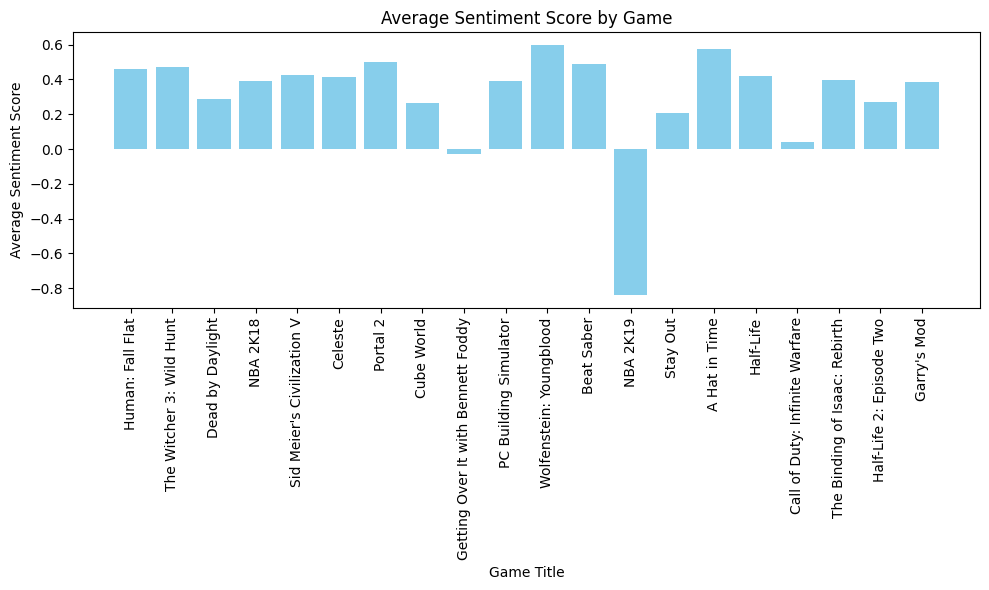

In [ ]:
# Convert to Pandas DataFrame for visualization
pandas_df = sentiment_summary.toPandas()
N = 20
top_n_df = pandas_df.head(N)
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_n_df['app_name'], top_n_df['avg_sentiment'], color='skyblue')
plt.xlabel('Game Title')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Game')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Now we will create a dataframe with only positive sentiment scores and another one with only negative sentiment scores. \
This way we can then group by the words and depending on their frequency see which are the top "most common" positive words and the top "most common" negative words.

In [ ]:
from pyspark.sql.functions import col, count
positive_df = df.filter(col("vader_sentiment") >0)
negative_df = df.filter(col("vader_sentiment") <0)
# Get top words for positive reviews
top_positive_words = positive_df.groupBy("words").agg(count("words").alias("count")).sort(col("count").desc())
# Get top words for negative reviews
top_negative_words = negative_df.groupBy("words").agg(count("words").alias("count")).sort(col("count").desc())
print("Top Positive words")
top_positive_words.show()
print("Top Negative words")
top_negative_words.show()

Top Positive words
+------------------+-----+
|             words|count|
+------------------+-----+
|            [good]| 1458|
|             [yes]| 1323|
|      [good, game]| 1208|
|     [great, game]|  739|
|             [fun]|  666|
|            [nice]|  492|
|[best, game, ever]|  342|
|      [nice, game]|  324|
|       [its, good]|  323|
|        [its, fun]|  251|
|         [amazing]|  218|
|      [very, good]|  199|
|       [fun, game]|  197|
|         [its, ok]|  195|
|            [cool]|  194|
|              [gg]|  187|
|   [amazing, game]|  181|
|        [love, it]|  173|
|[very, good, game]|  170|
|        [it, good]|  166|
+------------------+-----+
only showing top 20 rows

Top Negative words
+--------------------+-----+
|               words|count|
+--------------------+-----+
|                [no]|  125|
|               [meh]|   79|
|               [bad]|   47|
|              [shit]|   40|
|        [shit, game]|   39|
|         [bad, game]|   35|
|        [good, shit]|   22

Next we move to tagging. \
Tagging is the process of marking up a word in a text as corresponding to a particular part of speech, based on both its definition and its context.

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Create POS tags of each word in the review

In [ ]:
# Define the schema for the POS tags
pos_schema = ArrayType(StructType([
    StructField("word", StringType(), False),
    StructField("tag", StringType(), False)
]))

# Define a UDF with the correct return type
@udf(pos_schema)
def nltk_pos_tagger(text):
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger')

    tokens = word_tokenize(text)
    return [(word, pos) for word, pos in nltk.pos_tag(tokens)]

# Apply the UDF to the DataFrame
df_with_tags = df.withColumn("pos_tags", nltk_pos_tagger(df['review']))
df_with_tags.show(truncate=False)

+----+------+------------------------+---------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Recommendation system

Now that we have the POS tags we know what part of speech each word belongs to.\
**This way we can create a quick recommendation system.**\
It is generally known that *nouns* in sentences tend to give us well rounded idea of the context of the review.\
So now we will attempt to combine the *nouns* of each review as well as the given sentiment scores to try and build a recomendation system.

In [ ]:
# Drop the original features and prediction columns created earlier.
df_with_tags500 = df_with_tags.drop("features")
df_with_tags500 = df_with_tags500.drop("prediction")

First we make sure that all columns are in the correct format. \
This is why we using a *StringIndexer* for the author and game id.

In [ ]:
# We apply StringIndexer to all unique games so we have a new unique ID for each game
distinct_games_df = df_with_tags500.select("app_name").distinct()

# Now apply StringIndexer to create unique indices for each game
game_indexer = StringIndexer(inputCol="app_name", outputCol="game_index")
game_model = game_indexer.fit(distinct_games_df)
df_indexed = game_model.transform(distinct_games_df)


df_indexed.select("game_index", "app_name").orderBy("game_index").show(truncate=False)

+----------+----------------------------------+
|game_index|app_name                          |
+----------+----------------------------------+
|0.0       |A Hat in Time                     |
|1.0       |ARK: Survival Evolved             |
|2.0       |ATLAS                             |
|3.0       |Age of Empires II (2013)          |
|4.0       |American Truck Simulator          |
|5.0       |Among Us                          |
|6.0       |Arma 3                            |
|7.0       |Artifact                          |
|8.0       |Assassin's Creed Odyssey          |
|9.0       |Assassin's Creed Origins          |
|10.0      |Axiom Verge                       |
|11.0      |BATTALION 1944                    |
|12.0      |BATTLETECH                        |
|13.0      |Baba Is You                       |
|14.0      |Banished                          |
|15.0      |Batman: Arkham Asylum GOTY Edition|
|16.0      |BattleBlock Theater               |
|17.0      |BeamNG.drive                

In [ ]:
# Similar as before we create a new unique ID for each author
distinct_authors_df = df_with_tags500.select("author_steamid").distinct()

# Apply StringIndexer to create unique indices for each author ID
author_indexer = StringIndexer(inputCol="author_steamid", outputCol="author_index")
author_model = author_indexer.fit(distinct_authors_df)
df_authors_indexed = author_model.transform(distinct_authors_df)

# Show the mapping
df_authors_indexed.select("author_index", "author_steamid").orderBy("author_index").show(truncate=False)

+------------+-----------------+
|author_index|author_steamid   |
+------------+-----------------+
|0.0         |76561197960269348|
|1.0         |76561197960269704|
|2.0         |76561197960270230|
|3.0         |76561197960270501|
|4.0         |76561197960271009|
|5.0         |76561197960271098|
|6.0         |76561197960273228|
|7.0         |76561197960274942|
|8.0         |76561197960276196|
|9.0         |76561197960276392|
|10.0        |76561197960277916|
|11.0        |76561197960279882|
|12.0        |76561197960280160|
|13.0        |76561197960281354|
|14.0        |76561197960283604|
|15.0        |76561197960285521|
|16.0        |76561197960296687|
|17.0        |76561197960301814|
|18.0        |76561197960304942|
|19.0        |76561197960306296|
+------------+-----------------+
only showing top 20 rows



In [ ]:
# Join the indexed game names back to the main DataFrame
df_with_game_indices = df_with_tags500.join(df_indexed, on=["app_name"], how="left")

# Join the indexed author IDs back to the main DataFrame
final_indexed_df = df_with_game_indices.join(df_authors_indexed, on=["author_steamid"], how="left")

final_indexed_df.show(truncate=False)

+-----------------+------------------------+----+------+---------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now we will combine the noun tags and the vader sentiment score. This way we can build a recommendation system which takes into consideration the sentiment scores, as well as the "topic" of each review (based on the nouns used).

TF-IDF highlights nouns that are not only frequent in individual reviews but also relatively rare across all reviews. This helps the system to focus on specific features of games that are unique and appreciated by users, rather than common and generic terms.

By representing each review with TF-IDF scores of nouns, the system can create detailed profiles for both games (items) and users. Games can be characterized by the nouns that frequently appear in their positive reviews, and users can be profiled based on the nouns they frequently mention in their reviews.

 With the profiles in hand, the ALS algorithm can effectively match users to games that share similar noun profiles. If a user frequently mentions certain unique nouns in their reviews, the system can recommend games that are described using similar nouns in their reviews.

In [ ]:
# UDF to extract nouns and verbs from POS tags
def extract_words(tags, pos_to_extract):
    return [word for word, pos in tags if pos.startswith(pos_to_extract)]

extract_nouns = udf(lambda tags: extract_words(tags, 'NN'), ArrayType(StringType()))

# Apply UDF to DataFrame
dfaki = final_indexed_df.withColumn("nouns", extract_nouns(final_indexed_df.pos_tags))

# Feature extraction using TF-IDF
hashingTF = HashingTF(inputCol="nouns", outputCol="nouns_features")
tf_nouns_df = hashingTF.transform(dfaki)

idf = IDF(inputCol="nouns_features", outputCol="features")
idf_model = idf.fit(tf_nouns_df)
rescaled_data = idf_model.transform(tf_nouns_df)

# ALS Model for Recommendations
als = ALS(maxIter=5, regParam=0.01, userCol="author_index", itemCol="game_index", ratingCol="vader_sentiment", coldStartStrategy="drop")
model = als.fit(rescaled_data)

# show recommendations
recommendations = model.recommendForAllUsers(10)
recommendations.show(truncate=False)


+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|author_index|recommendations                                                                                                                                                                         |
+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1           |[{210, 0.5651945}, {70, 0.4507706}, {134, 0.43050018}, {167, 0.34894082}, {137, 0.3364722}, {194, 0.33543685}, {12, 0.26919723}, {15, 0.26511246}, {42, 0.26493114}, {197, 0.25750273}] |
|3           |[{49, 0.22751361}, {156, 0.22673099}, {154, 0.22148429}, {200, 0.1796025}, {9, 0.17219266}, {79, 0.17022575}, {195, 0.16851556}, {173, 0.15929349}, {89, 0.14753501}, {129, 0.1472426}] |


In [ ]:
# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="vader_sentiment", predictionCol="prediction")
rmse = evaluator.evaluate(model.transform(rescaled_data))
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.04294063536333363


## Graph Analysis

For this part we will take a look into a graph analysis for our dataset. \
We are able to build our graph using the video games and the review authors as **Vertices**, and the reviews themselves as **Edges**, and using as our *label* the weight.

In [ ]:
newdf = df.select(concat(lit("G"),df['app_id']).alias('Game_id'),concat(lit("A"),df['author_steamid']).alias('Author_id'),"recommended_numeric","app_name","votes_helpful")

vertices = newdf.select('Author_id').withColumnRenamed('Author_id',"id").distinct().withColumn('type',lit('Author'))\
            .union(newdf.select("Game_id").withColumnRenamed('Game_id',"id").distinct().withColumn('type',lit('Game')))

edges = newdf.select(newdf['Author_id'].alias('src'),newdf['Game_id'].alias('dst'),"recommended_numeric")

g = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Unfortunately due to the datasets great sparsity it is difficult to build a **well connected** graph. \
From now own having this knowledge in mind we continued our graph analysis attempts for clearly research purposes.

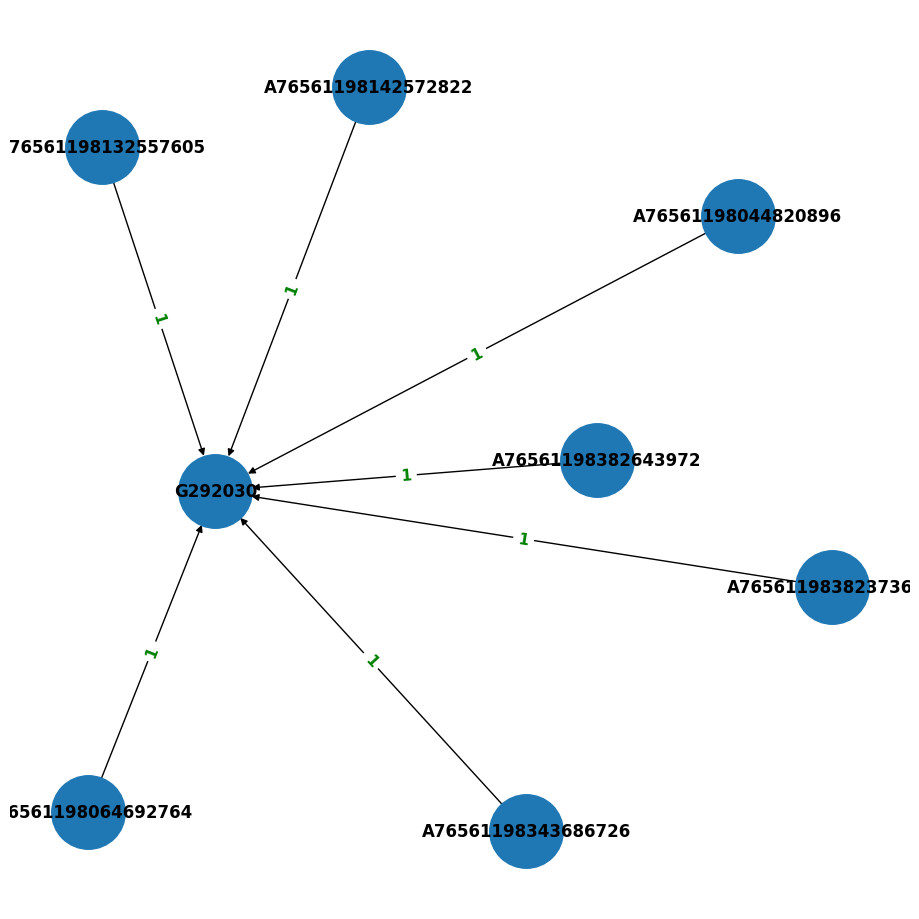

In [ ]:
# Function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list, weighted=False):
    # Creating a new plot figure
    plt.figure(figsize=(9,9))

    # Creating an empty directed graph using NetworkX
    gplot = nx.DiGraph()

    # Creating a dictionary to hold edge labels
    edge_labels = {}

    # Looping through the edge list and adding edges to the graph
    # Only adding the first 1000 edges for visualization purposes
    edge_char = "recommended_numeric"
    for row in edges.filter(col("dst")  =="G292030").select('src', "dst", edge_char).take(7):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row[edge_char]

    # Computing the layout of the graph using NetworkX's spring layout algorithm
    pos = nx.spring_layout(gplot)

    # Drawing the nodes and edges of the graph using NetworkX's draw function
    nx.draw(gplot, pos, with_labels=True, font_weight="bold", node_size=2800)

    # Adding the edge labels to the plot using NetworkX's draw_networkx_edge_labels function
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")

# Calling the plot_directed_graph function with the edges of a GraphFrame object as input
plot_directed_graph(g.edges)

Approaching the graph from a connectivity perspective we found the **degree** of each vertice helping us distinguish the more influential vertices.

In [ ]:
degree_centrality = g.degrees
degree_centrality.orderBy("degree", ascending=False).show(2)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------+------+
|     id|degree|
+-------+------+
|G105600| 10010|
|G359550|  9806|
+-------+------+
only showing top 2 rows



We then take the most *influential* authors regarding degree, and see how helpful their reviews have been.

In [ ]:
edges2 = newdf.select(newdf['Author_id'].alias('src'),newdf['Game_id'].alias('dst'),"votes_helpful")

g2 = GraphFrame(vertices, edges2)

most_helpful_games = edges2.groupBy("src").agg(sum("votes_helpful").alias("totalHelpfulness")).orderBy("totalHelpfulness", ascending=False)


influential_reviewers = degree_centrality.join(most_helpful_games, degree_centrality.id == most_helpful_games.src) \
                                         .orderBy("degree", ascending=False)
                                         #.drop("src")
influential_reviewers.show()

+------------------+------+------------------+----------------+
|                id|degree|               src|totalHelpfulness|
+------------------+------+------------------+----------------+
|A76561198073345281|     3|A76561198073345281|               0|
|A76561197986988419|     3|A76561197986988419|               1|
|A76561198241244626|     3|A76561198241244626|               4|
|A76561198847597923|     2|A76561198847597923|               1|
|A76561198084130756|     2|A76561198084130756|               0|
|A76561198055009794|     2|A76561198055009794|               0|
|A76561198074463298|     2|A76561198074463298|               0|
|A76561198073308122|     2|A76561198073308122|               0|
|A76561198126759802|     2|A76561198126759802|               1|
|A76561198314013441|     2|A76561198314013441|               2|
|A76561198989922136|     2|A76561198989922136|               0|
|A76561198236297390|     2|A76561198236297390|               1|
|A76561198105536471|     2|A765611981055

In [ ]:
edges_df = df.groupBy("author_steamid", "app_id") \
             .agg(avg("vader_sentiment").alias("avgSentimentScore"))

# Create vertices DataFrame for reviewers
reviewer_vertices = df.select("author_steamid").distinct().withColumnRenamed("author_steamid", "id")

# Create vertices DataFrame for games
game_vertices = df.select("app_id").distinct().withColumnRenamed("app_id", "id")

# Union the two vertices DataFrames
vertices6 = reviewer_vertices.unionByName(game_vertices)

# Create edges with the average sentiment score as the edge weight
edges6 = edges_df.selectExpr("author_steamid as src", "app_id as dst", "avgSentimentScore as weight")

# Create the GraphFrame
g6 = GraphFrame(vertices6, edges6)

Next we attempted through a graph approach to see which games had the most positive average sentiment and which games had the most negative average sentiment score.

In [ ]:
# Top 5 games with the highest average sentiment score
top_positive_games = g6.edges.groupBy("dst").agg(avg("weight").alias("avgSentiment")).orderBy("avgSentiment", ascending=False)
top_positive_games.show(5)

# Top 5 games with the lowest average sentiment score
top_negative_games = g6.edges.groupBy("dst").agg(avg("weight").alias("avgSentiment")).orderBy("avgSentiment", ascending=True)
top_negative_games.show(5)

+------+------------------+
|   dst|      avgSentiment|
+------+------------------+
|673880|0.9554000198841095|
|560130|0.9531000256538391|
|332200|0.9492999911308289|
|598330|0.9472000002861023|
|606280|0.9258500039577484|
+------+------------------+
only showing top 5 rows

+-------+--------------------+
|    dst|        avgSentiment|
+-------+--------------------+
| 841370| -0.8395000100135803|
| 543900|-0.42669999599456787|
| 712100| -0.4248999956762418|
|1229490| -0.4018999934196472|
| 583470|-0.38179999589920044|
+-------+--------------------+
only showing top 5 rows



Here we used the LPA algorithm to help us detect **communities** in graphs. \
The idea was, that authors that play similar games, or games that belong to the same series, belong in the same **communities**. \
We hoped this would give us an insight as to how different **communities** behave while reviewing.

In [ ]:
# Use the Label Propagation Algorithm (LPA) to detect communities
communities = g6.labelPropagation(maxIter=5)

# Join the communities DataFrame with the original reviews DataFrame to get sentiment scores
community_sentiments = communities.join(df, communities.id == df.author_steamid)
community_sentiments.show()

+-----------------+-------------+-------+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------+
|               id|        label|    _c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   a

Here we calculate the average sentiment of each **community**

In [ ]:
# Calculate the average sentiment score for each community
average_community_sentiment = community_sentiments.groupBy("label") \
    .agg(avg("vader_sentiment").alias("avgSentimentScore"))

# Show the average sentiment for each community
average_community_sentiment.orderBy("avgSentimentScore", ascending=False).show()

+-------------+------------------+
|        label| avgSentimentScore|
+-------------+------------------+
| 824633720834|0.9554000198841095|
| 223338299393|0.9531000256538391|
| 575525617664|0.9492999911308289|
| 704374636544|0.9472000002861023|
| 266287972354|0.9258500039577484|
|1451698946048|0.9227499961853027|
| 987842478081|0.9047999978065491|
|1254130450432|0.8884999752044678|
| 223338299394|0.8590999841690063|
|1486058684417|0.8248000144958496|
| 704374636545|0.8173999935388565|
| 979252543488|0.7437666853268942|
|1056561954816|0.7161999940872192|
|  25769803776|0.7057999968528748|
| 661424963584|0.6624333262443542|
| 506806140928|0.6609055598576864|
| 944892805121|0.6579187531024218|
|1245540515842|0.6448000073432922|
| 910533066754|0.6431888871722751|
| 944892805120| 0.630199983716011|
+-------------+------------------+
only showing top 20 rows



In [ ]:
community_games = community_sentiments.join(average_community_sentiment, ['label'], 'inner')


In [ ]:
community_games.show(2)

+-----------+-----------------+-------+------+---------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------+------------------+
|      label|               id|    _c0|app_id| app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_s

In [ ]:
# join the average sentiment score with the community sentiments to get game IDs for each label
community_games = community_sentiments.join(average_community_sentiment, ['label'], 'inner')

community_games = community_games.withColumnRenamed("app_id", "game_id")


# Join the games DataFrame to get the app names
community_games_with_names = community_games.join(df, community_games.game_id == df.app_id, 'inner')
community_games_with_names.show(1)

+------------+-----------------+-------+-------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------------+----------------------+-------------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------+------------------+-------+-------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+

In [ ]:
community_games.select(community_games.label,"avgSentimentScore",community_games.app_name).distinct().orderBy("label", "avgSentimentScore", ascending=False)

# Show the games for each label with the average sentiment
community_games.select("label","game_id","app_name","avgSentimentScore").show(5)

+-----------+-------+---------+------------------+
|      label|game_id| app_name| avgSentimentScore|
+-----------+-------+---------+------------------+
|60129542564| 863550|HITMAN™ 2|0.3754142852766173|
|60129542564| 863550|HITMAN™ 2|0.3754142852766173|
|60129542564| 863550|HITMAN™ 2|0.3754142852766173|
|60129542564| 863550|HITMAN™ 2|0.3754142852766173|
|60129542564| 863550|HITMAN™ 2|0.3754142852766173|
+-----------+-------+---------+------------------+
only showing top 5 rows



Here we unfortunately realised that our dataset sparsity, regarding the graph **Connectivity**, did not allow the LPA algorithm to form normal **communities**. \
 Instead each different game, along with its reviewers formed a community **Between them selves**.

In [ ]:
games_per_label = community_games.groupBy("label") \
    .agg(collect_set("app_name").alias("games"))

# Show the distinct games for each community label
games_per_label.show(200,truncate=False)

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label        |games                                                                                                                                                                                                                                                                                           

So finally we just tried to see which reviewers would give higher or lower sentiment scores.

In [ ]:
# You can also explore which reviewers tend to give higher or lower sentiment scores
top_reviewers_by_sentiment = edges6.groupBy("src").agg(avg("weight").alias("avgSentiment")).orderBy("avgSentiment", ascending=False)
top_reviewers_by_sentiment.show()

+-----------------+------------------+
|              src|      avgSentiment|
+-----------------+------------------+
|76561198059982604|               1.0|
|76561198396161416|               1.0|
|76561198446630712|0.9998999834060669|
|76561198984251553|0.9998000264167786|
|76561198174731795|0.9998000264167786|
|76561198315253774|0.9994999766349792|
|76561198067320933|0.9991000294685364|
|76561198096886459|0.9991000294685364|
|76561198052958172|0.9991000294685364|
|76561198051381744|0.9990000128746033|
|76561198104019493|0.9988999962806702|
|76561198841173082|0.9986000061035156|
|76561198079731786|0.9986000061035156|
|76561198197492182|0.9984999895095825|
|76561198141068354|0.9983999729156494|
|76561198414131190|0.9983000159263611|
|76561198122833272|0.9980999827384949|
|76561198084686754|0.9980000257492065|
|76561198371396296|0.9976999759674072|
|76561198070285892|0.9976000189781189|
+-----------------+------------------+
only showing top 20 rows

